In [1]:
# import modules 
#%matplotlib notebook
import json
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import os
import csv
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import datetime
from time import strptime
import re
import scipy.stats as st

In [2]:
# Read In 
# Nicks Exchange Rate Tradition Currency CSV File Input 
file = "Data/Exchange_Rate_Report1.csv"
clean_foreign_ex = pd.read_csv(file,header=2)
clean_foreign_ex = clean_foreign_ex[:-34]
clean_foreign_ex

,Date,Australian dollar (AUD),Chinese yuan (CNY),Euro (EUR),Japanese yen (JPY),Swiss franc (CHF),U.K. pound (GBP),U.S. dollar (USD)
0,29-Apr-2013,1.0312,NaN,1.3113,NaN,0.93930,1.55220,1.0
1,30-Apr-2013,1.0368,NaN,1.3072,97.91,0.93630,1.54850,1.0
2,1-May-2013,1.0367,NaN,NaN,97.25,NaN,1.55690,1.0
3,2-May-2013,1.0231,6.2082,1.3191,97.22,0.92880,1.55740,1.0
4,3-May-2013,1.0271,6.2152,1.3114,NaN,0.93220,1.55550,1.0
...,...,...,...,...,...,...,...,...
1944,22-Feb-2021,0.7876,6.4683,1.2133,105.48,0.89815,1.40220,1.0
1945,23-Feb-2021,0.7923,6.4611,1.2143,NaN,0.90030,1.40890,1.0
1946,24-Feb-2021,0.7913,6.4598,1.2146,105.50,0.90730,1.41355,1.0
1947,25-Feb-2021,0.797,6.4509,1.2225,106.05,0.90595,1.41360,1.0


In [3]:
# Read In 
# Daves input cryptocurrency data 

cryptodatafile = 'Data/merged_crypto_data.csv'
RawCrypto_df = pd.read_csv(cryptodatafile)
RawCrypto_df.head()

,Coin,Date,Open,High,Low,Close,Volume,Market Cap
0,bitcoin,"Feb 28, 2021",46194.02,46716.43,43241.62,45137.77,5.344389e+10,"$841,428,977,515"
1,bitcoin,"Feb 27, 2021",46344.77,48253.27,45269.03,46188.45,4.591095e+10,"$860,978,135,421"
2,bitcoin,"Feb 26, 2021",47180.46,48370.79,44454.84,46339.76,3.509680e+11,"$863,752,275,053"
3,bitcoin,"Feb 25, 2021",49709.08,51948.97,47093.85,47093.85,5.450657e+10,"$877,766,126,138"
4,bitcoin,"Feb 24, 2021",48835.09,51290.14,47213.50,49705.33,6.369552e+10,"$926,393,090,751"


In [4]:
# Clean up 
# Foreign Exchange Data Cleanup 
# Set columns for foreign exchange 
clean_foreign_ex.columns = ['Date','Australian Dollar (AUD)','Chinese Yuan (CNY)','Euro (EUR)','Japanese Yen (JPY)','Swiss Franc (CHF)','U.K. Pound (GBP)','U.S. Dollar (USD)']

#reduce dataframe to currencies we need.  AUD, Pound, EURO, Yuan, Yen, Swiss. Set AUD to Float dtype. 
forex_clean = clean_foreign_ex[["Date", "Australian Dollar (AUD)", "Euro (EUR)", "U.K. Pound (GBP)", "U.S. Dollar (USD)"]].copy()
forex_clean['Australian Dollar (AUD)'] = forex_clean['Australian Dollar (AUD)'].astype(float)
forex_clean.head()

,Date,Australian Dollar (AUD),Euro (EUR),U.K. Pound (GBP),U.S. Dollar (USD)
0,29-Apr-2013,1.0312,1.3113,1.5522,1.0
1,30-Apr-2013,1.0368,1.3072,1.5485,1.0
2,1-May-2013,1.0367,NaN,1.5569,1.0
3,2-May-2013,1.0231,1.3191,1.5574,1.0
4,3-May-2013,1.0271,1.3114,1.5555,1.0


In [5]:
# Clean Up 
# Nicks's Traditional Currency Cleanup
# Read in String date format, convert to Datestamp obejct and read in as dates 
def monthToNum(shortMonth):
    return {
            'jan' : 1,
            'feb' : 2,
            'mar' : 3,
            'apr' : 4,
            'may' : 5,
            'jun' : 6,
            'jul' : 7,
            'aug' : 8,
            'sep' : 9, 
            'oct' : 10,
            'nov' : 11,
            'dec' : 12
    }[shortMonth]
splitdate = pd.DataFrame()
splitdate[['day','month','year']] = forex_clean['Date'].str.split("\s|-", 2, expand=True)
splitdate['month'] = splitdate['month'].str.lower()
splitdate['month'] = splitdate['month'].apply(monthToNum)

# Insert Datestamp YYYMMDD Column for sorting 
forex_clean.insert(1,'Datestamp',pd.to_datetime(splitdate[['year','month','day']]))

# Fill Empty Cells 
for_ex_clean = forex_clean.fillna(method='ffill')
for_ex_clean

forex_clean

,Date,Datestamp,Australian Dollar (AUD),Euro (EUR),U.K. Pound (GBP),U.S. Dollar (USD)
0,29-Apr-2013,2013-04-29,1.0312,1.3113,1.55220,1.0
1,30-Apr-2013,2013-04-30,1.0368,1.3072,1.54850,1.0
2,1-May-2013,2013-05-01,1.0367,NaN,1.55690,1.0
3,2-May-2013,2013-05-02,1.0231,1.3191,1.55740,1.0
4,3-May-2013,2013-05-03,1.0271,1.3114,1.55550,1.0
...,...,...,...,...,...,...
1944,22-Feb-2021,2021-02-22,0.7876,1.2133,1.40220,1.0
1945,23-Feb-2021,2021-02-23,0.7923,1.2143,1.40890,1.0
1946,24-Feb-2021,2021-02-24,0.7913,1.2146,1.41355,1.0
1947,25-Feb-2021,2021-02-25,0.7970,1.2225,1.41360,1.0


In [6]:
# Clean Up 
# Dave's Crypto Currency Cleanup

# Function to convert "Date" to usable / sortable format 
def monthToNum(shortMonth):
    return {
            'jan' : 1,
            'feb' : 2,
            'mar' : 3,
            'apr' : 4,
            'may' : 5,
            'jun' : 6,
            'jul' : 7,
            'aug' : 8,
            'sep' : 9, 
            'oct' : 10,
            'nov' : 11,
            'dec' : 12
    }[shortMonth]
splitdate = pd.DataFrame()
splitdate[['month','day','year']] = RawCrypto_df['Date'].str.split("\s|,", 2, expand=True)
splitdate['month'] = splitdate['month'].str.lower()
splitdate['month'] = splitdate['month'].apply(monthToNum)

# Insert Datestamp YYYMMDD Column for sorting 
RawCrypto_df.insert(1,'Datestamp',pd.to_datetime(splitdate[['year','month','day']]))
RawCrypto_df.dtypes

# Recast Coin names as Title-case 
RawCrypto_df['Coin'] = RawCrypto_df['Coin'].str.title()

# Write RawCrypto df to file
RawCrypto_df.to_csv('Data/RawCrypto_df.csv')
RawCrypto_df

,Coin,Datestamp,Date,Open,High,Low,Close,Volume,Market Cap
0,Bitcoin,2021-02-28,"Feb 28, 2021",46194.02,46716.43,43241.62,45137.77,5.344389e+10,"$841,428,977,515"
1,Bitcoin,2021-02-27,"Feb 27, 2021",46344.77,48253.27,45269.03,46188.45,4.591095e+10,"$860,978,135,421"
2,Bitcoin,2021-02-26,"Feb 26, 2021",47180.46,48370.79,44454.84,46339.76,3.509680e+11,"$863,752,275,053"
3,Bitcoin,2021-02-25,"Feb 25, 2021",49709.08,51948.97,47093.85,47093.85,5.450657e+10,"$877,766,126,138"
4,Bitcoin,2021-02-24,"Feb 24, 2021",48835.09,51290.14,47213.50,49705.33,6.369552e+10,"$926,393,090,751"
...,...,...,...,...,...,...,...,...,...
26277,Waves,2016-06-07,"Jun 07, 2016",0.77,1.08,0.77,0.84,4.593200e+04,$0
26278,Waves,2016-06-06,"Jun 06, 2016",0.71,1.17,0.71,0.77,9.557300e+04,$0
26279,Waves,2016-06-05,"Jun 05, 2016",0.59,1.11,0.58,0.71,4.170000e+04,$0
26280,Waves,2016-06-04,"Jun 04, 2016",1.09,1.29,0.58,0.59,4.912000e+03,$0


In [7]:
# Exploration  - Nick 
# Nick Traditional Currency Groupby Tables 
groupby_mean_df = forex_clean.groupby(pd.Grouper(key='Datestamp',freq='1M')).mean()
forex_groupby_std_df = forex_clean.groupby(pd.Grouper(key='Datestamp',freq='1M')).std()
forex_groupby_var_df = forex_clean.groupby(pd.Grouper(key='Datestamp',freq='1M')).var()

In [26]:
# Exploration - David 
# Dave's Coinlist and Colourlist 

coinlist = ['Bitcoin','Ethereum','Litecoin','Iota','Monero','Dash']

colourdict = {'Bitcoin':'dodgerblue',
'Ethereum':'orangered',
'Litecoin':'orange',
'Iota':'greenyellow',
'Monero':'forestgreen',
'Dash':'darkturquoise'}

In [9]:
# Exploration - Nick
# Nick's Traditional Currency & Bitcoin Dataframe - create dataframes for combining later 
cryptodatafile = 'Data/RawCrypto_df.csv'
RawCrypto_df = pd.read_csv(cryptodatafile)

RawCrypto_df['Datestamp'] = pd.to_datetime(RawCrypto_df['Datestamp'], yearfirst= True)

ethereum_df = RawCrypto_df.loc[RawCrypto_df['Coin'] == 'Ethereum'].sort_values(by='Datestamp')
bitcoin_df = RawCrypto_df.loc[RawCrypto_df['Coin'] == 'Bitcoin'].sort_values(by='Datestamp')
litecoin_df = RawCrypto_df.loc[RawCrypto_df['Coin'] == 'Litecoin'].sort_values(by='Datestamp')

bitcoin_std_groupbymonth_df = bitcoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).std()
ethereum_std_groupbymonth_df = ethereum_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).std()
litecoin_std_groupbymonth_df = litecoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).std()

bitcoin_var_groupbymonth_df = bitcoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).var()
ethereum_var_groupbymonth_df = ethereum_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).var()
litecoin_var_groupbymonth_df = litecoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).var()

bitcoin_mean_groupbymonth_df = bitcoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).mean()
ethereum_mean_groupbymonth_df = ethereum_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).mean()
litecoin_mean_groupbymonth_df = litecoin_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).mean()


bitcoin_mean_groupbymonth_df.head()

,Unnamed: 0,Open,High,Low,Close,Volume
Datestamp,,,,,,
2013-04-30,2861.5,139.220000,147.210000,134.025000,141.770000,0.0
2013-05-31,2845.0,120.292258,123.948710,114.253226,119.992581,0.0
2013-06-30,2814.5,108.856667,111.300667,104.602000,107.761333,0.0
2013-07-31,2784.0,90.311290,93.869032,86.719677,90.512258,0.0
2013-08-31,2753.0,113.041935,116.002258,111.387742,113.905161,0.0


In [55]:
# Exploration - Nick
# Create combined mean and STD DEV dataframe with Trad Currency and Crypto Currency 
combined_std_df = pd.DataFrame()
combined_mean_df = pd.DataFrame()

combined_std_df['Australian Dollar (AUD)'] = forex_groupby_std_df['Australian Dollar (AUD)']
combined_std_df['Euro (EUR)'] = forex_groupby_std_df['Euro (EUR)']
combined_std_df['U.K. Pound (GBP)'] = forex_groupby_std_df['U.K. Pound (GBP)']

combined_std_df['Bitcoin'] = bitcoin_std_groupbymonth_df['Close']
combined_std_df['Ethereum'] = ethereum_std_groupbymonth_df['Close']
combined_std_df['Litecoin'] = litecoin_std_groupbymonth_df['Close']

combined_mean_df['Bitcoin'] = bitcoin_mean_groupbymonth_df['Close']
combined_mean_df['Ethereum'] = ethereum_mean_groupbymonth_df['Close']
combined_mean_df['Litecoin'] = litecoin_mean_groupbymonth_df['Close']


In [11]:
# Exploration - Nick
# Calculate Mean for AUD, CNY, EUR, JPY, CHF, GBP

AUD_mean = forex_clean['Australian Dollar (AUD)'].mean()
EURO_mean = forex_clean['Euro (EUR)'].mean()
GBP_mean = forex_clean['U.K. Pound (GBP)'].mean()
USD_mean = forex_clean['U.S. Dollar (USD)'].mean()
print(f"The mean for AUD is {AUD_mean}")
print(f"The mean for EURO is {EURO_mean}")
print(f"The mean for GBP is {GBP_mean}")
print(f"The mean for USD is {USD_mean}")

The mean for AUD is 0.7730917910447763
The mean for EURO is 1.1756792099792075
The mean for GBP is 1.4040946957878329
The mean for USD is 1.0


In [12]:
# Push the remade DataFrame to a new CSV file
for_ex_clean.to_csv("Data/for_ex_clean.csv",
                  encoding="utf-8", index=False, header=True)

In [13]:
# Dave - Exploration
# Loop and create coin-based dataframes for each cryptocurrency 

for coin in coinlist:
    globals()[f"{coin}_df"] = RawCrypto_df.loc[RawCrypto_df['Coin'] == coin].sort_values(by='Datestamp')
    exec(f"{coin}_groupbymonth_df = {coin}_df.groupby(pd.Grouper(key='Datestamp',freq='1M'))")

Bitcoin_groupbymonth_df.mean()

,Unnamed: 0,Open,High,Low,Close,Volume
Datestamp,,,,,,
2013-04-30,2861.5,139.220000,147.210000,134.025000,141.770000,0.000000e+00
2013-05-31,2845.0,120.292258,123.948710,114.253226,119.992581,0.000000e+00
2013-06-30,2814.5,108.856667,111.300667,104.602000,107.761333,0.000000e+00
2013-07-31,2784.0,90.311290,93.869032,86.719677,90.512258,0.000000e+00
2013-08-31,2753.0,113.041935,116.002258,111.387742,113.905161,0.000000e+00
...,...,...,...,...,...,...
2020-10-31,135.0,11791.306774,12018.847742,11648.077097,11886.978387,3.389918e+10
2020-11-30,104.5,16450.120667,16945.980667,16064.074333,16645.757333,3.643816e+10
2020-12-31,74.0,21680.541290,22354.685806,21229.361613,21983.136774,3.910515e+10


In [14]:
# Nick -Exploration and Analysis
# get max and min values of traditional currencies 

#MAX and MIN
aud_max = for_ex_clean['Australian Dollar (AUD)'].max()
aud_min = for_ex_clean['Australian Dollar (AUD)'].min()

euro_max = for_ex_clean['Euro (EUR)'].max()
euro_min = for_ex_clean['Euro (EUR)'].min()

gbp_max = for_ex_clean['U.K. Pound (GBP)'].max()
gbp_min = for_ex_clean['U.K. Pound (GBP)'].min()

print(f"The max value of USD vs AUD is {aud_max} and the min value of USD vs AUD is {aud_min}.")
print(f"The max value of USD vs EURO is {euro_max} and the min value of USD vs EURO is {euro_min}.")
print(f"The max value of USD vs GBP is {gbp_max} and the min value of USD vs GBP is {gbp_min}.")
print(f"---------------------------------------------------------------------------------------------------")


#Standard Deviation
aud_std = for_ex_clean['Australian Dollar (AUD)'].std()
euro_std = for_ex_clean['Euro (EUR)'].std()
gbp_std = for_ex_clean['U.K. Pound (GBP)'].std()

print(f"The Standard Deviation for the AUD is {aud_std}.")
print(f"The Standard Deviation for the Euro is {euro_std}.")
print(f"The Standard Deviation for the GBP is {gbp_std}.")
print(f"---------------------------------------------------------------------------------------------------")

#Mean
aud_mean = for_ex_clean['Australian Dollar (AUD)'].mean()
euro_mean = for_ex_clean['Euro (EUR)'].mean()
gbp_mean = for_ex_clean['U.K. Pound (GBP)'].mean()

print(f"The Mean for the AUD is {aud_mean}.")
print(f"The Mean for the Euro is {euro_mean}.")
print(f"The Mean for the GBP is {gbp_mean}.")
print(f"---------------------------------------------------------------------------------------------------")

#Mode
aud_mode = for_ex_clean['Australian Dollar (AUD)'].mode()
euro_mode = for_ex_clean['Euro (EUR)'].mode()
gbp_mode = for_ex_clean['U.K. Pound (GBP)'].mode()

print(f"The Mode for the AUD is {aud_mode}.")
print(f"The Mode for the Euro is {euro_mode}.")
print(f"The Mode for the GBP is {gbp_mode}.")
print(f"---------------------------------------------------------------------------------------------------")


#Variance 
aud_var = for_ex_clean['Australian Dollar (AUD)'].var()
euro_var = for_ex_clean['Euro (EUR)'].var()
gbp_var = for_ex_clean['U.K. Pound (GBP)'].var()

print(f"The Variance for the AUD is {aud_var}.")
print(f"The Variance for the Euro is {euro_var}.")
print(f"The Variance for the GBP is {gbp_var}.")
print(f"---------------------------------------------------------------------------------------------------")


The max value of USD vs AUD is 1.0368 and the min value of USD vs AUD is 0.5571.
The max value of USD vs EURO is 1.3953 and the min value of USD vs EURO is 1.0364.
The max value of USD vs GBP is 1.7161 and the min value of USD vs GBP is 1.1531.
---------------------------------------------------------------------------------------------------
The Standard Deviation for the AUD is 0.0848522762252411.
The Standard Deviation for the Euro is 0.09272083195486291.
The Standard Deviation for the GBP is 0.144559546383502.
---------------------------------------------------------------------------------------------------
The Mean for the AUD is 0.7730066187788619.
The Mean for the Euro is 1.1756381221139014.
The Mean for the GBP is 1.4040067470497704.
---------------------------------------------------------------------------------------------------
The Mode for the AUD is 0    0.7000
1    0.7093
2    0.7522
3    0.7615
dtype: float64.
The Mode for the Euro is 0    1.1215
dtype: float64.
The Mo

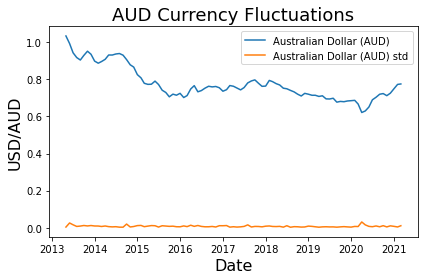

In [15]:
# Nick - Exploration 
# AUD Currency Fluctuations
plt.plot(groupby_mean_df['Australian Dollar (AUD)'])
plt.plot(forex_groupby_std_df['Australian Dollar (AUD)']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/AUD",size=16)
plt.title("AUD Currency Fluctuations", size=18)
plt.gca().legend(('Australian Dollar (AUD)','Australian Dollar (AUD) std'))
plt.tight_layout()
plt.savefig("Output/AUD Currency Fluctuations.png,dpi=300")

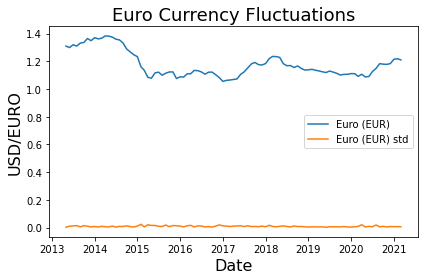

In [16]:
# Nick - Exploration 
#Euro Currency Fluctuations
plt.plot(groupby_mean_df['Euro (EUR)'])
plt.plot(forex_groupby_std_df['Euro (EUR)']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/EURO",size=16)
plt.title("Euro Currency Fluctuations", size=18)
plt.gca().legend(('Euro (EUR)','Euro (EUR) std'))
plt.tight_layout()
plt.savefig("Output/Euro Currency Fluctuations.png,dpi=300")

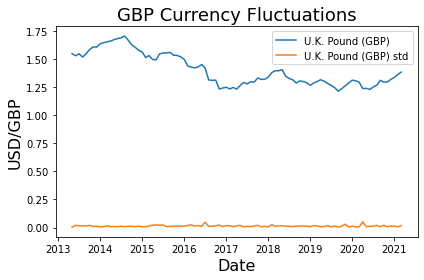

In [17]:
# Nick - Exploration 
#GBP Currency Fluctuations
plt.plot(groupby_mean_df['U.K. Pound (GBP)'])
plt.plot(forex_groupby_std_df['U.K. Pound (GBP)']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/GBP",size=16)
plt.title("GBP Currency Fluctuations", size=18)
plt.gca().legend(('U.K. Pound (GBP)','U.K. Pound (GBP) std'))
plt.tight_layout()
plt.savefig("Output/GBP Currency Fluctuations.png,dpi=300")

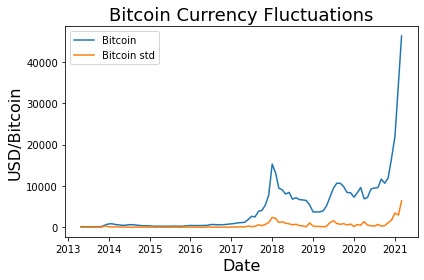

In [56]:
# Nick - Exploration 
#Bitcoin Fluctuations 
plt.plot(combined_mean_df['Bitcoin'])
plt.plot(combined_std_df['Bitcoin']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/Bitcoin",size=16)
plt.title("Bitcoin Currency Fluctuations", size=18)
plt.gca().legend(('Bitcoin','Bitcoin std'))
plt.tight_layout()
plt.savefig("Output/Bitcoin Currency Fluctuations.png,dpi=300")

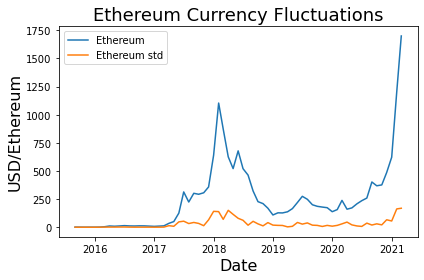

In [57]:
# Nick - Exploration 
#Ethereum Fluctuations
plt.plot(combined_mean_df['Ethereum'])
plt.plot(combined_std_df['Ethereum']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/Ethereum",size=16)
plt.title("Ethereum Currency Fluctuations", size=18)
plt.gca().legend(('Ethereum','Ethereum std'))
plt.tight_layout()
plt.savefig("Output/Ethereum Currency Fluctuations.png,dpi=300")

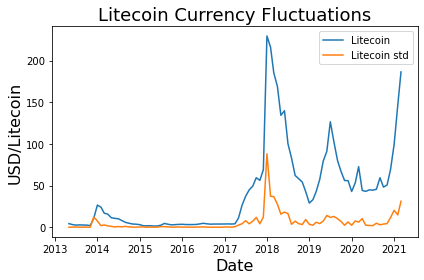

In [58]:
# Nick - Exploration 
#Litecoin Fluctuations
plt.plot(combined_mean_df['Litecoin'])
plt.plot(combined_std_df['Litecoin']) 
plt.xlabel("Date",size=16)
plt.ylabel("USD/Litecoin",size=16)
plt.title("Litecoin Currency Fluctuations", size=18)
plt.gca().legend(('Litecoin','Litecoin std'))
plt.tight_layout()
plt.savefig("Output/Litecoin Currency Fluctuations.png,dpi=300")

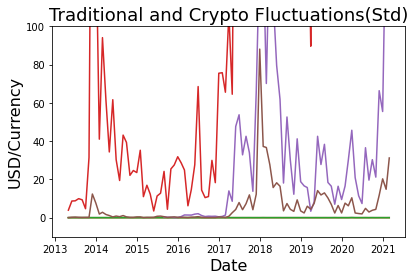

In [21]:
# Nick - Exploration 
#Combined Crypto and Traditional Currencies Fluctuation in STD
plt.plot(combined_std_df)
#plt.legend(loc = 'upper left')
plt.ylim(-10, 100)
plt.xlabel("Date",size=16)
plt.ylabel("USD/Currency",size=16)
plt.title("Traditional and Crypto Fluctuations(Std)", size=18)
plt.tight_layout()
plt.savefig("Output/Traditional Vs Crypto-Currencies Fluctuations.png,dpi=300")

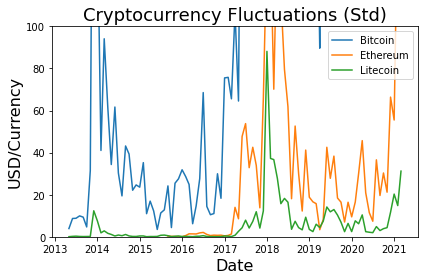

In [22]:
# Nick - Graphing 
# Graph STD DEV of crypto fluctuations 
plt.plot(combined_std_df['Bitcoin'])
plt.plot(combined_std_df['Ethereum'])
plt.plot(combined_std_df['Litecoin'])
plt.ylim(0, 100)
plt.xlabel("Date",size=16)
plt.ylabel("USD/Currency",size=16)
plt.title("Cryptocurrency Fluctuations (Std)", size=18)
plt.gca().legend(('Bitcoin','Ethereum', 'Litecoin'))
#plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig("Output/Crypto-Currencies Fluctuations.png,dpi=300")

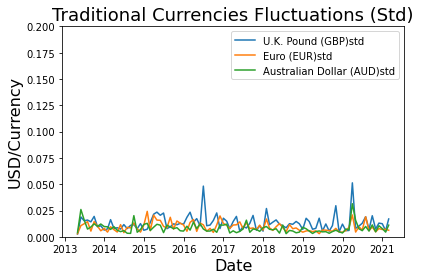

In [23]:
# Nick - Graphing and Analysis 
#Traditional Cryptocurrency Fluctuations in STD
plt.plot(forex_groupby_std_df['U.K. Pound (GBP)']) 
plt.plot(forex_groupby_std_df['Euro (EUR)']) 
plt.plot(forex_groupby_std_df['Australian Dollar (AUD)'])
plt.ylim(0, 0.2)
plt.xlabel("Date",size=16)
plt.ylabel("USD/Currency",size=16)
plt.title("Traditional Currencies Fluctuations (Std)", size=18)
plt.gca().legend(('U.K. Pound (GBP)std','Euro (EUR)std', 'Australian Dollar (AUD)std'))
plt.tight_layout()
plt.savefig("Output/Traditional Currency Fluctuations.png,dpi=300")

<Figure size 432x288 with 0 Axes>

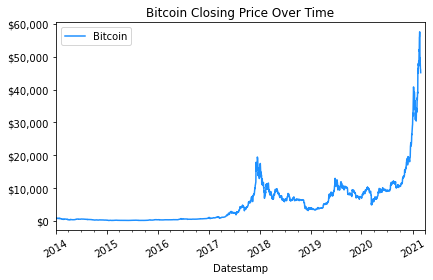

<Figure size 432x288 with 0 Axes>

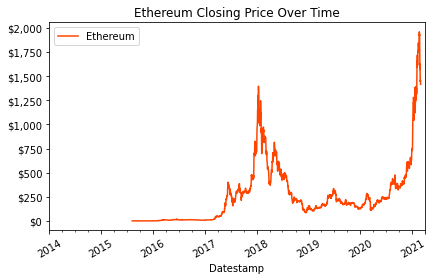

<Figure size 432x288 with 0 Axes>

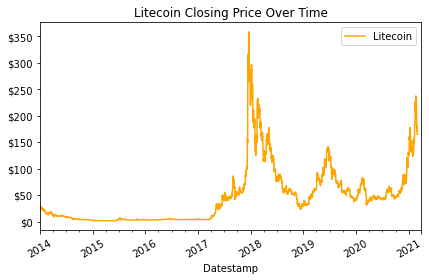

<Figure size 432x288 with 0 Axes>

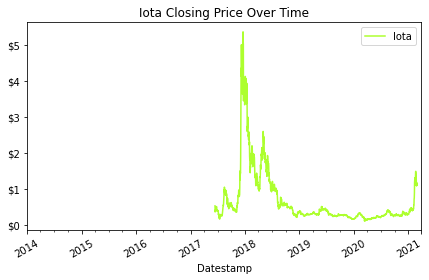

<Figure size 432x288 with 0 Axes>

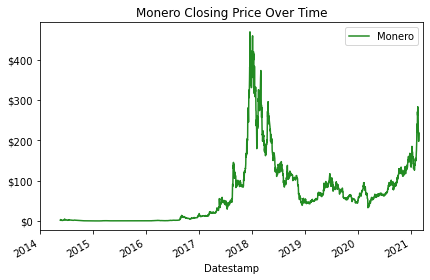

<Figure size 432x288 with 0 Axes>

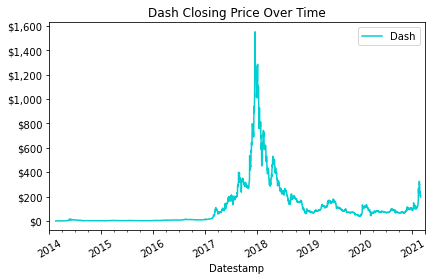

In [24]:
# David - Anaylsis and Graphing
# Plot Cryptocurrency Closing Price over time  
# xticklist = [2014,2015,2016,2017,2018,2019,2020,2021,2022]
for coin in coinlist:
    plt.figure()
    exec(f"ax = {coin}_df.plot('Datestamp','Close',label='{coin}',color=colourdict['{coin}'])")
    exec(f"plt.title('{coin} Closing Price Over Time')")
    plt.setp(ax.get_xticklabels(), rotation = 30)
    ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2021-03-28'))
    plt.tight_layout()
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    exec(f"ax.yaxis.set_tick_params(which='major', labelcolor='black')")
    exec(f"plt.savefig('Output/{coin}_Closing_Price_Over_Time.png',dpi=300)")

plt.show()

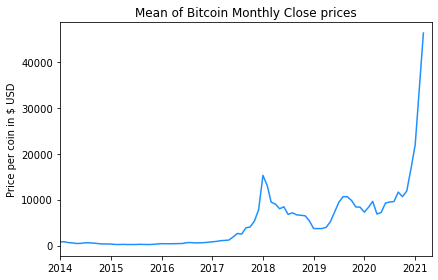

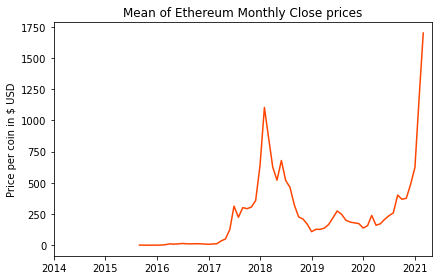

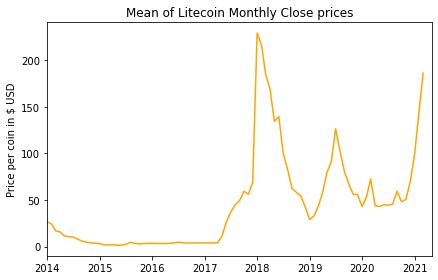

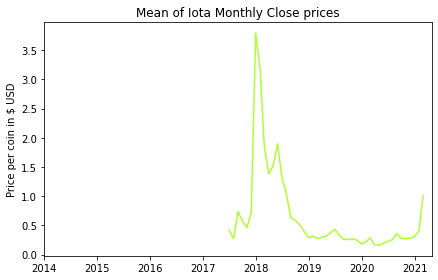

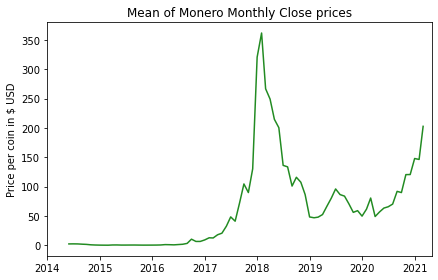

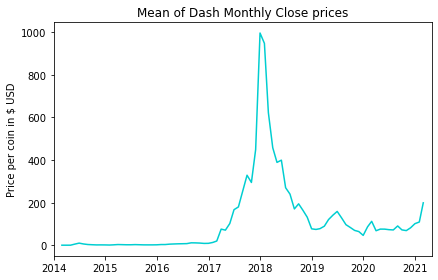

In [25]:
# David - Anaylsis and Graphing
# Plot Cryptocurrency Average Monthly Price 
for coin in coinlist:
    plt.figure()
    exec(f"plt.plot({coin}_groupbymonth_df[['Close']].mean(), color=colourdict['{coin}'])")
    exec(f"plt.title('Mean of {coin} Monthly Close prices')")
    plt.xlim([datetime.date(2014,1,1), datetime.date(2021,4,28)])
    plt.tight_layout()
    plt.ylabel('Price per coin in $ USD')
    exec(f"plt.savefig('Output/{coin}_Average Monthly Price.png',dpi=300)")

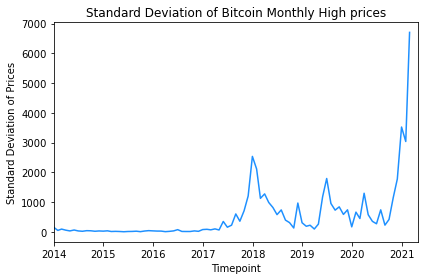

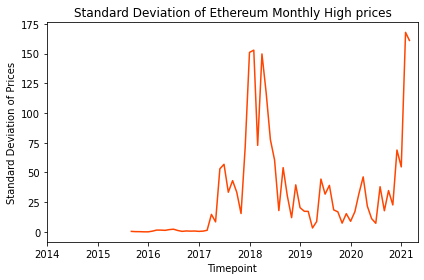

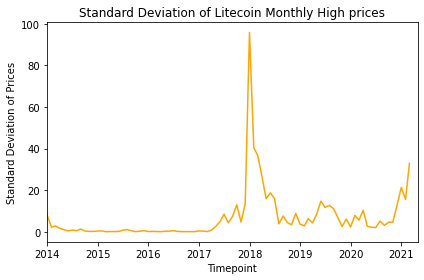

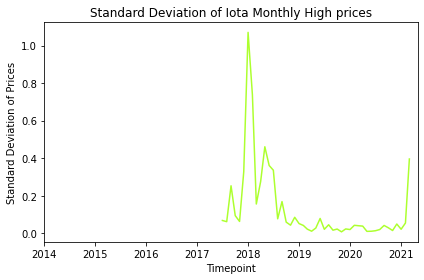

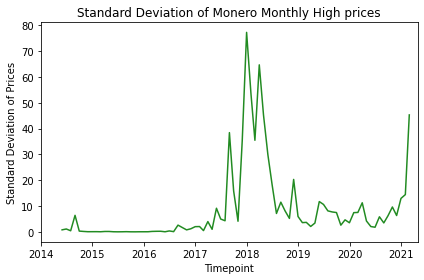

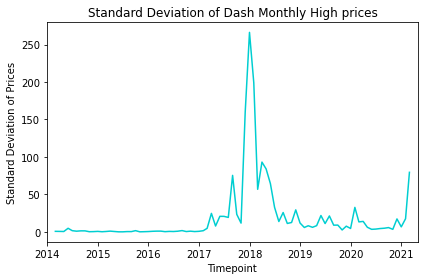

In [26]:
# David - Anaylsis and Graphing
# Plot Cryptocurrency Standard Deviation of Monthly Prices
for coin in coinlist:
    plt.figure()
    exec(f"plt.plot({coin}_groupbymonth_df[['High']].std(),color=colourdict['{coin}'])")
    exec(f"plt.title('Standard Deviation of {coin} Monthly High prices')")
    plt.xlim([datetime.date(2014,1,1), datetime.date(2021,4,28)])
    plt.ylabel('Standard Deviation of Prices')
    plt.xlabel("Timepoint")
    plt.tight_layout()
    exec(f"plt.savefig('Output/{coin}_Standard Deviation of Monthly High Prices.png',dpi=300)")

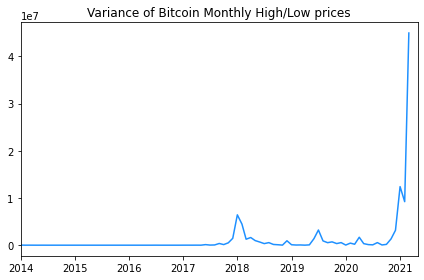

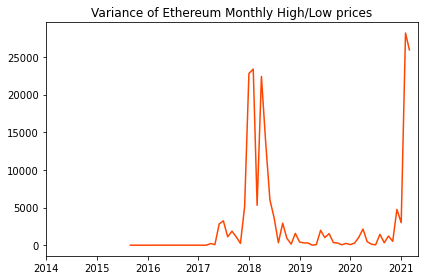

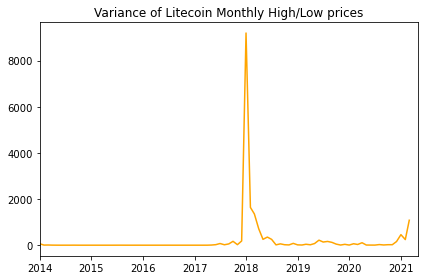

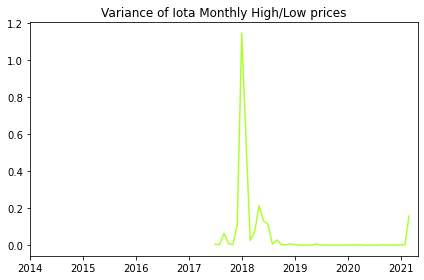

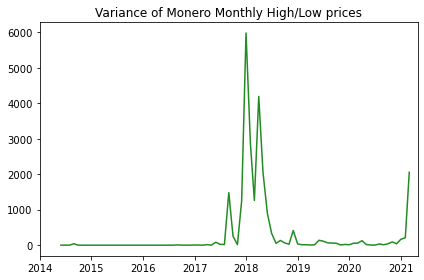

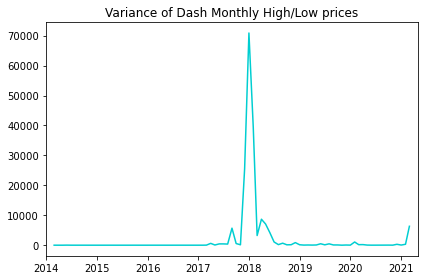

In [27]:
# David - Anaylsis and Graphing
# Plot Cryptocurrency Variance of Monthly Prices
for coin in coinlist:
    plt.figure()
    exec(f"plt.plot({coin}_groupbymonth_df[['High']].var(),color=colourdict['{coin}'])")
    exec(f"plt.title('Variance of {coin} Monthly High/Low prices')")  
    plt.xlim([datetime.date(2014,1,1), datetime.date(2021,4,28)]) 
    plt.tight_layout()
    exec(f"plt.savefig('Output/{coin} Variance of Monthly High Price.png',dpi=300)")

<Figure size 432x288 with 0 Axes>

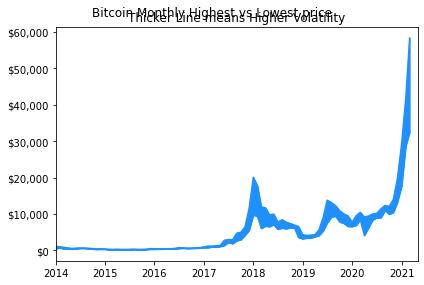

<Figure size 432x288 with 0 Axes>

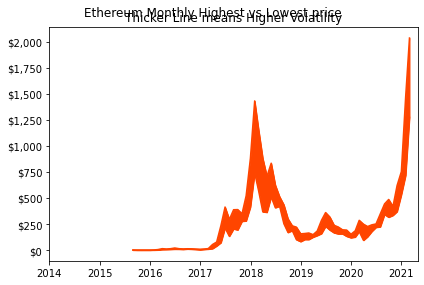

<Figure size 432x288 with 0 Axes>

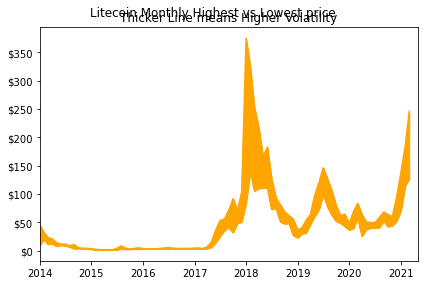

<Figure size 432x288 with 0 Axes>

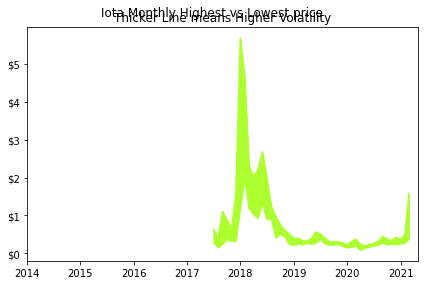

<Figure size 432x288 with 0 Axes>

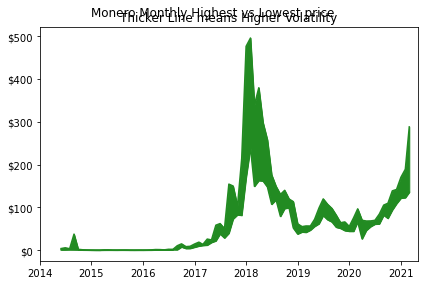

<Figure size 432x288 with 0 Axes>

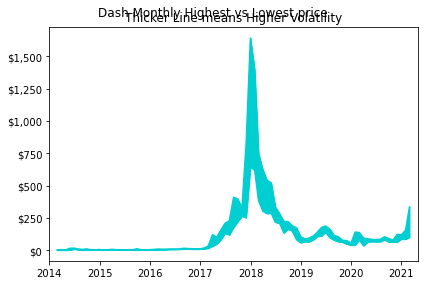

In [28]:
# David - Anaylsis and Graphing
# Plot Cryptocurrency Min vs Max Prices 

from matplotlib.ticker import FuncFormatter

for coin in coinlist:
    # Create new Delta Dataframe
    exec(f"{coin}_delta = {coin}_groupbymonth_df['High'].max()")
    exec(f"{coin}_delta = pd.DataFrame({coin}_delta)")
    exec(f"{coin}_delta['Low'] = {coin}_groupbymonth_df['Low'].min()")
    exec(f"{coin}_delta['HighLowDelta'] = {coin}_delta['High'] - {coin}_delta['Low']")
    exec(f"{coin}_delta['Close'] = {coin}_groupbymonth_df['Close'].max()")
    exec(f"{coin}_delta['CloseDiff'] = {coin}_delta['Close'].diff()")
    exec(f"{coin}_delta['PctChange'] = ({coin}_delta['CloseDiff']) / ({coin}_delta['Close'] - {coin}_delta['CloseDiff']) * 100 ")    
    # Plot Graphs
    plt.figure()
    fig, ax = plt.subplots()
    exec(f"plt.plot({coin}_delta['High'], color=colourdict['{coin}'])")
    exec(f"plt.plot({coin}_delta['Low'], color=colourdict['{coin}'])")
    exec(f"{coin}_delta['x1'] = {coin}_delta.index")
    exec(f"plt.fill_between(x={coin}_delta['x1'], y1={coin}_delta['Low'], y2={coin}_delta['High'], color=colourdict['{coin}'])")
    exec(f"plt.suptitle('{coin} Monthly Highest vs Lowest price')")
    exec(f"plt.title('Thicker Line means Higher Volatility')")
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.xlim([datetime.date(2014,1,1), datetime.date(2021,4,28)])
    plt.tight_layout()
    exec(f"plt.savefig('Output/{coin} Monthly Highest vs Lowest Price.png',dpi=300)")


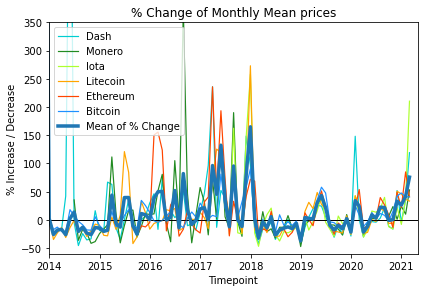

In [29]:
# Analysis and Graphing - David
# Create % Change dataframe and plot results 

PctChange_df = pd.DataFrame()
for coin in coinlist:
    # copy PctChange colum of various DFs into CoinPctChange Column in One DF
    exec(f"PctChange_df['{coin}PctChange'] = {coin}_delta['PctChange']")

# calculate the mean % change of all coins in table 
PctChange_df['mean'] = PctChange_df.iloc[:, 0:5].mean(axis=1)

# plot results 
for coin in reversed(coinlist):
    exec(f"plt.plot({coin}_delta[['PctChange']],color=colourdict['{coin}'], linewidth =1.2, label='{coin}' )")
    plt.xlabel('Timepoint')
    plt.ylabel('% Increase / Decrease')
    plt.xlim([datetime.date(2014,1,1), datetime.date(2021,4,28)])
    plt.ylim(-60,350)
    plt.axhline(y=0, color = 'black', linewidth = .5)
    plt.tight_layout()

# plot results continued and save 
exec(f"plt.title('% Change of Monthly Mean prices')")
plt.plot(PctChange_df['mean'], linewidth=3.5, label='Mean of % Change')
plt.legend(loc="upper left")
exec(f"plt.savefig('Output/All Coins - Percent Change in Monthly Prices.png',dpi=300)")

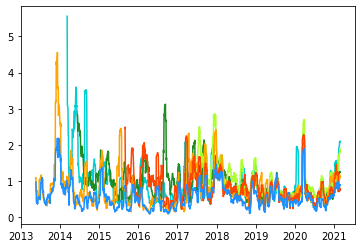

In [30]:
# David - Anaylsis and Graphing
# Calculate Log, Square and Square Root of rolling average 
window = 21
dpy = 252
ann_factor = dpy / window

for coin in reversed(coinlist):
    exec(f"{coin}Log_df = pd.DataFrame()")
    exec(f"{coin}Log_df['Datestamp'] = {coin}_df['Datestamp']")
    exec(f"{coin}Log_df['Close'] = {coin}_df['Close']")
    exec(f"{coin}Log_df = {coin}Log_df.set_index(['Datestamp'])")
    exec(f"{coin}Log_df['Close'] = np.log({coin}Log_df['Close'])")

    exec(f"{coin}Log_df['LogRtn'] = {coin}Log_df[['Close']].diff()")
    exec(f"{coin}Log_df['real_var'] = np.square({coin}Log_df['LogRtn']).rolling(window).sum() * ann_factor")
    exec(f"{coin}Log_df['real_vol'] = np.sqrt({coin}Log_df['real_var'])")

    exec(f"plt.plot({coin}Log_df['real_vol'], color=colourdict['{coin}'])")
plt.show()

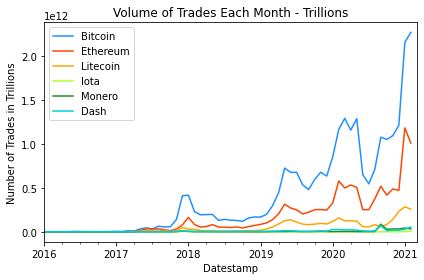

In [31]:
# David - Analysis and Graphing 
# Calculate Volume of Trades Each month

for coin in coinlist:
    exec(f"{coin}_groupbymonth_df['Volume'].sum().plot(label='{coin}', color=colourdict['{coin}'])")
    plt.title('Volume of Trades Each Month - Trillions')
    plt.ylabel('Number of Trades in Trillions')
    plt.xlim([datetime.date(2016,1,1), datetime.date(2021,3,14)])
    # plt.gca.legend((coinlist))
    plt.legend(loc="upper left")
    plt.tight_layout()
    exec(f"plt.savefig('Output/All Coins - Volume of Trades Per Month.png',dpi=300)")
plt.show()

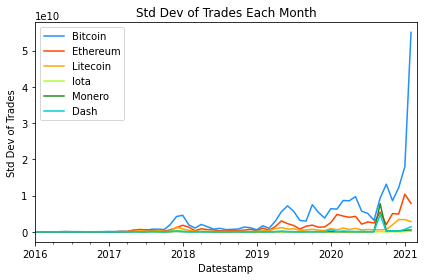

In [32]:
# David - Analysis and Graphing
# Calculate Standard Deviation of Trade Volumes 

for coin in coinlist:
    exec(f"{coin}_groupbymonth_df['Volume'].std().plot(label='{coin}', color=colourdict['{coin}'])")
    plt.title('Std Dev of Trades Each Month')
    plt.ylabel('Std Dev of Trades')
    plt.xlim([datetime.date(2016,1,1), datetime.date(2021,3,14)])
    # plt.gca.legend((coinlist))
    plt.legend(loc="upper left")
    plt.tight_layout()
    exec(f"plt.savefig('Output/All Coins - Standard Deviation of Trades Per Month.png',dpi=300)")
plt.show()

C:\Users\Danie\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


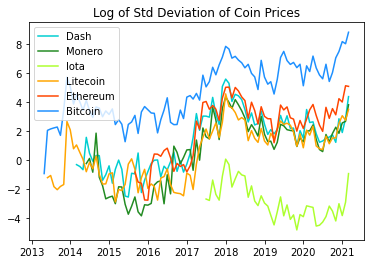

In [33]:
# David - Analysis and Graphing
# Calculate Log return of Standard Deviation of Coin Prices 

for coin in reversed(coinlist):
    plt.figure
    exec(f"plt.plot(np.log({coin}_groupbymonth_df[['High']].std()),label={'coin'}, color=colourdict['{coin}'])")
    plt.title('Log of Std Deviation of Coin Prices')
    ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2021-03-28'))  
    plt.legend(loc="upper left")
    exec(f"plt.savefig('Output/All Coins - Log Return of Standard Deviation of Coin Prices.png',dpi=300)")
plt.show()

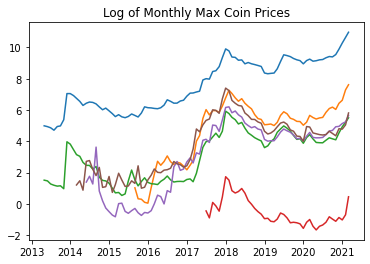

In [34]:
# David - Analysis and Graphing
# Calculate Log return of Monthly highest coin prices 

for coin in coinlist:
    plt.figure
    exec(f"plt.plot(np.log({coin}_groupbymonth_df[['High']].max()))")
    plt.title('Log of Monthly Max Coin Prices')
    ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2021-03-28'))  


### Cleaning media data files

#### Google Trends files clean up

In [7]:
# Milena - import Google Trends files for each coin
bitcoin_file = 'Data/bitcoin.csv'
ethereum_file = 'Data/ethereum.csv'
litecoin_file = 'Data/litecoin.csv'
iota_file = 'Data/iota.csv'
monero_file = 'Data/monero.csv'
dash_file = 'Data/dash_crypto.csv'
stratis_file = 'Data/stratis_crypto.csv'

m_bitcoin_df = pd.read_csv(bitcoin_file,header=1)
m_ethereum_df = pd.read_csv(ethereum_file,header=1)
m_litecoin_df = pd.read_csv(litecoin_file,header=1)
m_iota_df = pd.read_csv(iota_file,header=1)
m_monero_df = pd.read_csv(monero_file,header=1)
m_dash_df = pd.read_csv(dash_file,header=1)
m_stratis_df = pd.read_csv(stratis_file,header=1)

In [8]:
# Milena - create one dataframe with all files
google_trends_df = pd.merge(m_bitcoin_df, m_ethereum_df, how='outer', on='Month')
google_trends_df = pd.merge(google_trends_df, m_litecoin_df, how='outer', on='Month')
google_trends_df = pd.merge(google_trends_df, m_iota_df, how='outer', on='Month')
google_trends_df = pd.merge(google_trends_df, m_monero_df, how='outer', on='Month')
google_trends_df = pd.merge(google_trends_df, m_dash_df, how='outer', on='Month')
google_trends_df = pd.merge(google_trends_df, m_stratis_df, how='outer', on='Month')

In [9]:
# Milena - rename columns
google_trends_df.columns = ['Date', 'Bitcoin', 'Ethereum', 'Litecoin', 'Iota', 'Monero', 'Dash', 'Stratis']

In [10]:
# Milena - clean data types
google_trends_df['Ethereum'] = google_trends_df['Ethereum'].str.replace('<','')
google_trends_df["Ethereum"] = google_trends_df.Ethereum.astype('int64')

In [11]:
# Milena - create datestamp column
google_trends_df.insert(0,'Datestamp',(pd.to_datetime(google_trends_df['Date'], format="%Y-%m") + MonthEnd(1)))
del google_trends_df['Date']
google_trends_df = google_trends_df.set_index('Datestamp')
google_trends_df.insert(0,'Datestamp', google_trends_df.index)
google_trends_df.head()

,Datestamp,Bitcoin,Ethereum,Litecoin,Iota,Monero,Dash,Stratis
Datestamp,,,,,,,,
2013-04-30,2013-04-30,8,1,7,3,1,0,0
2013-05-31,2013-05-31,3,1,3,2,1,0,0
2013-06-30,2013-06-30,2,1,2,2,1,0,0
2013-07-31,2013-07-31,2,1,2,2,1,0,0
2013-08-31,2013-08-31,2,1,2,2,1,0,0


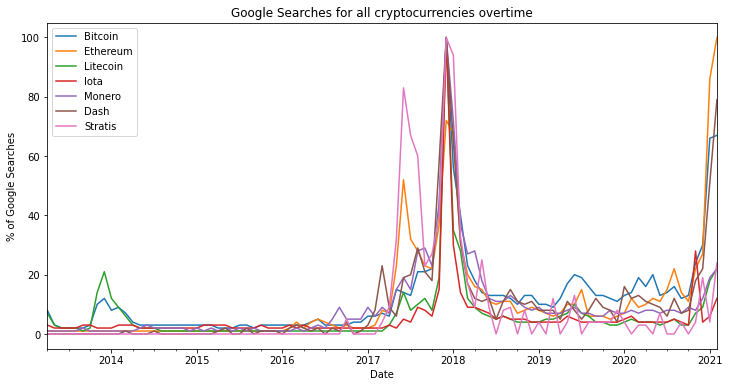

In [12]:
# Milena - Exploration 
#Combined Google Search results for each coin
google_trends_df.plot(x='Datestamp', figsize=(12,6))
plt.title('Google Searches for all cryptocurrencies overtime')
plt.ylabel('% of Google Searches')
plt.xlabel('Date')
plt.savefig("Output/GoogleSearches.png")

#### News API file clean up

In [13]:
# Milena - import news_search_API output file
news_api_file = 'Data/data_news_api.csv'

news_df = pd.read_csv(news_api_file)

news_df.head()

,Month,Year,Num_of_articles
0,4,2013,3.0
1,5,2013,1.0
2,6,2013,0.0
3,7,2013,0.0
4,8,2013,0.0


In [14]:
# Milena - create datestamp column
monthslist = news_df['Month'].unique()
for month in news_df['Month']:    
    if month < 10: 
        news_df['Month'] = news_df['Month'].replace(month,'0' + str(month))

In [15]:
news_df.insert(0,'Dates',news_df["Year"].astype(str) + "-" + news_df["Month"].astype(str))
news_df.insert(0,'Datestamp',(pd.to_datetime(news_df['Dates'], format="%Y-%m") + MonthEnd(1)))

In [16]:
del news_df['Dates']
del news_df['Month']
del news_df['Year']
news_df = news_df.set_index('Datestamp')

In [17]:
news_df.insert(0,'Datestamp', news_df.index)
news_df.head()

,Datestamp,Num_of_articles
Datestamp,,
2013-04-30,2013-04-30,3.0
2013-05-31,2013-05-31,1.0
2013-06-30,2013-06-30,0.0
2013-07-31,2013-07-31,0.0
2013-08-31,2013-08-31,0.0


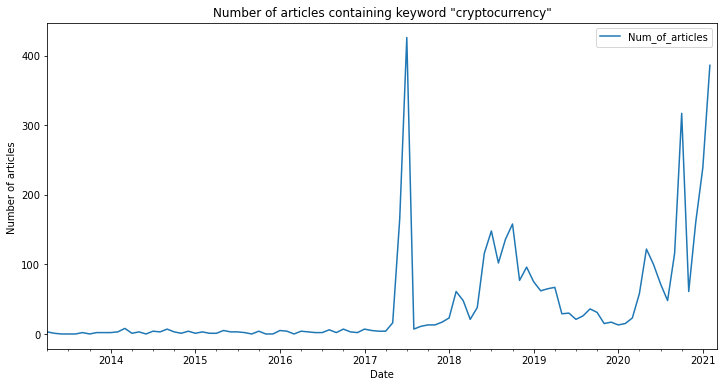

In [18]:
# Milena - Exploration 
#Number of articles containing keyword "cryptocurrency
news_df.plot(x='Datestamp', figsize=(12,6))
plt.title('Number of articles containing keyword "cryptocurrency"')
plt.ylabel('Number of articles ')
plt.xlabel('Date')
plt.savefig("Output/NumberOfArticles.png")

In [19]:
# Milena - Exploration 
#Closing Prices per day for all cryptocurrencies

In [20]:
currency_df = RawCrypto_df.loc[(RawCrypto_df['Coin'] == 'Bitcoin') | 
                             (RawCrypto_df['Coin'] == 'Ethereum') | 
                             (RawCrypto_df['Coin'] == 'Litecoin') | 
                             (RawCrypto_df['Coin'] == 'Iota') | 
                             (RawCrypto_df['Coin'] == 'Monero') | 
                             (RawCrypto_df['Coin'] == 'Dash') |
                             (RawCrypto_df['Coin'] == 'Stratis'), ['Coin','Datestamp','Close','Volume']].copy()

In [21]:
currency_df = currency_df.sort_values(["Coin", "Datestamp"]).reset_index(drop=True)
currency_df.head()

,Coin,Datestamp,Close,Volume
0,Bitcoin,2013-04-29,144.54,0.0
1,Bitcoin,2013-04-30,139.00,0.0
2,Bitcoin,2013-05-01,116.99,0.0
3,Bitcoin,2013-05-02,105.21,0.0
4,Bitcoin,2013-05-03,97.75,0.0


In [22]:
m_coinlist = ['Bitcoin', 'Dash', 'Ethereum', 'Iota', 'Litecoin', 'Monero', 'Stratis']

In [23]:
# summary dataframes for each coin

for coin in m_coinlist:
    
    # create multiple dataframes for each coin 
    globals()[f"m_{coin}_df"] = currency_df.loc[currency_df['Coin'] == coin]
    
    # create multiple tables for each coin grouped by month  
    exec(f"{coin}_groupbymonth_sr = m_{coin}_df.groupby(pd.Grouper(key='Datestamp',freq='1M'))")
    
    # create multiple dataframes for each coin grouped by month and with .sum() applied   
    exec(f"{coin}_sum_df = {coin}_groupbymonth_sr.sum()")
    
    # create multiple dataframes for each coin grouped by month and with .mean() applied
    exec(f"{coin}_mean_df = {coin}_groupbymonth_sr.mean()")  

In [24]:
m_colourdict = {'Bitcoin':'royalblue',
'Ethereum':'firebrick',
'Litecoin':'gold',
'Iota':'limegreen',
'Monero':'mediumturquoise',
'Dash':'darkviolet',
'Stratis':'palevioletred'}

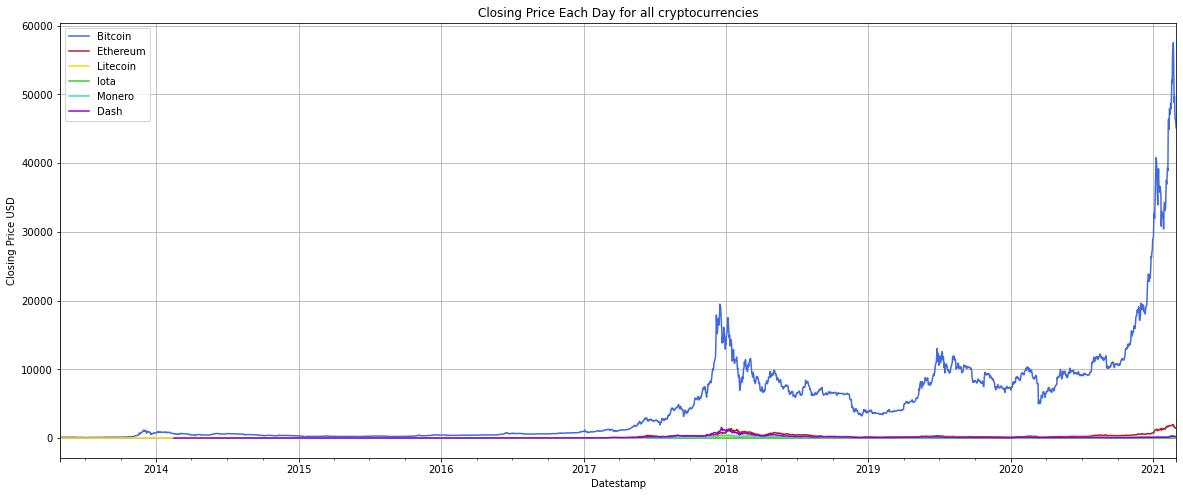

In [27]:
fig, ax = plt.subplots()

for coin in coinlist:
    for key, grp in currency_df.groupby(['Coin']):
        if key == coin:
            ax = grp.plot(ax=ax, kind='line', x='Datestamp', y='Close', color=m_colourdict[coin], label=key, grid= True, figsize=(20, 8))
            plt.title('Closing Price Each Day for all cryptocurrencies')
            plt.ylabel('Closing Price USD')

In [28]:
#Log of the Closing Prices per day for all cryptocurrencies

In [29]:
currency_log_df = currency_df.copy()

currency_log_df['Close'] = np.log(currency_log_df['Close'])

currency_log_df.head()

,Coin,Datestamp,Close,Volume
0,Bitcoin,2013-04-29,4.973556,0.0
1,Bitcoin,2013-04-30,4.934474,0.0
2,Bitcoin,2013-05-01,4.762088,0.0
3,Bitcoin,2013-05-02,4.655958,0.0
4,Bitcoin,2013-05-03,4.582413,0.0


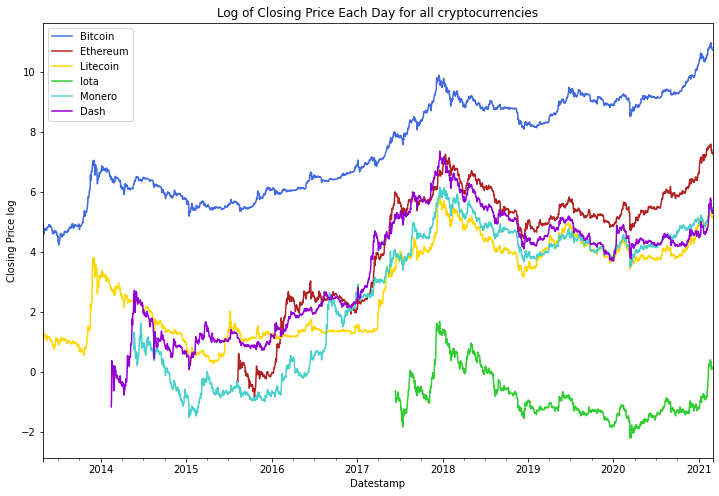

In [30]:
fig1, ax1 = plt.subplots()

for coin in coinlist:
    for key, grp in currency_log_df.groupby(['Coin']):
        if key == coin:
            ax1 = grp.plot(ax=ax1, kind='line', x='Datestamp', y='Close', color=m_colourdict[coin], label=key, figsize=(12, 8))
            plt.title('Log of Closing Price Each Day for all cryptocurrencies')
            plt.ylabel('Closing Price log')

In [31]:
# Milena - Analysis and Graphing
#Volatility for all cryptocurrencies

In [32]:
#### Daily % change of Closing Price

In [33]:
currency_vol_df = currency_df.copy()

In [35]:
currency_vol_df.loc[currency_vol_df.Coin.eq(currency_vol_df.Coin.shift()) == False, 'daily%change'] = None
currency_vol_df.loc[currency_vol_df.Coin.eq(currency_vol_df.Coin.shift()) == True, 'daily%change'] = round(currency_vol_df['Close'].pct_change()*100,2)

In [36]:
currency_vol_df.head()

,Coin,Datestamp,Close,Volume,daily%change
0,Bitcoin,2013-04-29,144.54,0.0,NaN
1,Bitcoin,2013-04-30,139.00,0.0,-3.83
2,Bitcoin,2013-05-01,116.99,0.0,-15.83
3,Bitcoin,2013-05-02,105.21,0.0,-10.07
4,Bitcoin,2013-05-03,97.75,0.0,-7.09


In [37]:
currency_vol_df.iloc[2857:2867,:]

,Coin,Datestamp,Close,Volume,daily%change
2857,Bitcoin,2021-02-23,48824.43,1.061020e+11,-9.93
2858,Bitcoin,2021-02-24,49705.33,6.369552e+10,1.80
2859,Bitcoin,2021-02-25,47093.85,5.450657e+10,-5.25
2860,Bitcoin,2021-02-26,46339.76,3.509680e+11,-1.60
2861,Bitcoin,2021-02-27,46188.45,4.591095e+10,-0.33
2862,Bitcoin,2021-02-28,45137.77,5.344389e+10,-2.27
2863,Dash,2014-02-15,0.31,2.111900e+04,NaN
2864,Dash,2014-02-16,0.41,2.801700e+04,32.26
2865,Dash,2014-02-17,1.45,1.786180e+05,253.66
2866,Dash,2014-02-18,1.04,1.607790e+05,-28.28


In [38]:
#### Monthly Volatility for each coin

for coin in m_coinlist:
    
    # create multiple dataframes for each coin
    globals()[f"new_{coin}_df"] = currency_vol_df.loc[currency_vol_df['Coin'] == coin, ['Datestamp','daily%change']]   
    
    # create multiple tables for each coin grouped by month  
    exec(f"new_{coin}_std_df = new_{coin}_df.groupby(pd.Grouper(key='Datestamp',freq='1M')).std()")
    
    #rename the column - the column values are now changed by the .std() function applied to the gropuby() object
    exec(f"new_{coin}_std_df.columns = ['dailystd%']")
    
    #calculate monthly % standard deviation by multiplying daily standard dev by square root of avg days per month
    exec(f"new_{coin}_std_df['monthlystd%'] = new_{coin}_std_df['dailystd%'] * np.sqrt(365/12)")

In [41]:
new_Bitcoin_std_df.head()

,dailystd%,monthlystd%
Datestamp,,
2013-04-30,NaN,NaN
2013-05-31,5.169285,28.509281
2013-06-30,3.245947,17.901821
2013-07-31,5.833841,32.174397
2013-08-31,2.651257,14.622028


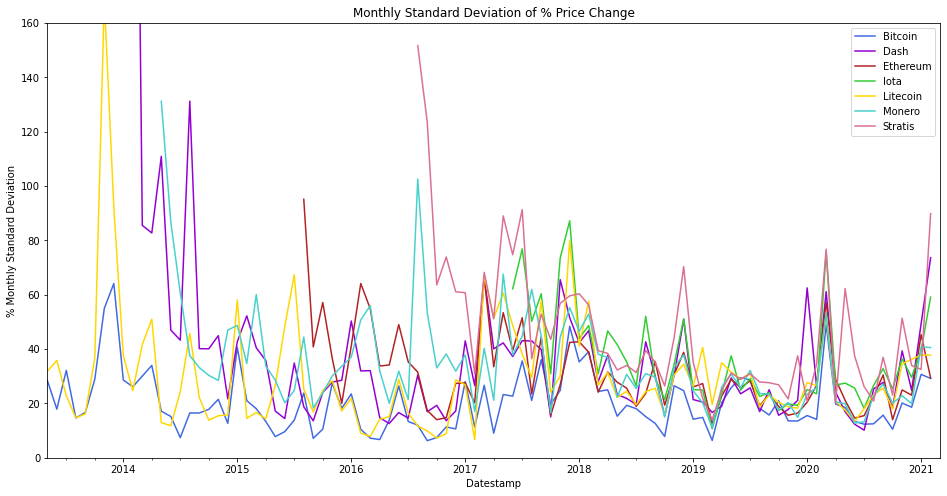

In [42]:
#### Plot Monthly Volatility for each coin
for coin in m_coinlist:
    exec(f"new_{coin}_std_df['monthlystd%'].plot(label='{coin}', color=m_colourdict['{coin}'], figsize=(16, 8))")
    plt.title('Monthly Standard Deviation of % Price Change')
    plt.legend(loc="best")
    plt.ylabel('% Monthly Standard Deviation')
    plt.ylim(0, 160)
    plt.xlim([datetime.date(2013,5,1), datetime.date(2021,3,1)])
    exec(f"plt.savefig('Output/Volatility.png')")

In [43]:
# Milena - Analysis and Graphing
#Summary table with monthly performance indicators for further analysis

In [44]:
for coin in m_coinlist:
    # create new summary dataframes for each coin
    exec(f"{coin}_groupbymth_all_df = new_{coin}_std_df.copy()")  
    
    # add column with a sum of volume 
    exec(f"{coin}_groupbymth_all_df['monthlyvolsum'] = {coin}_sum_df['Volume'].tolist()")
    
    # add column with a monthly average Close Price  
    exec(f"{coin}_groupbymth_all_df['monthlyavgprice'] = {coin}_mean_df['Close'].tolist()")
    
    # insert 'Datestamp' column (for plotting graphs Version 1)
    exec(f"{coin}_groupbymth_all_df.insert(0,'Datestamp',{coin}_groupbymth_all_df.index)")

In [45]:
Bitcoin_groupbymth_all_df

,Datestamp,dailystd%,monthlystd%,monthlyvolsum,monthlyavgprice
Datestamp,,,,,
2013-04-30,2013-04-30,NaN,NaN,0.000000e+00,141.770000
2013-05-31,2013-05-31,5.169285,28.509281,0.000000e+00,119.992581
2013-06-30,2013-06-30,3.245947,17.901821,0.000000e+00,107.761333
2013-07-31,2013-07-31,5.833841,32.174397,0.000000e+00,90.512258
2013-08-31,2013-08-31,2.651257,14.622028,0.000000e+00,113.905161
...,...,...,...,...,...
2020-10-31,2020-10-31,1.909417,10.530685,1.050875e+12,11886.978387
2020-11-30,2020-11-30,3.653773,20.151036,1.093145e+12,16645.757333
2020-12-31,2020-12-31,3.375620,18.616985,1.212260e+12,21983.136774


In [ ]:
# Milena - Analysis and Graphing
#Graphs showing relation between people's intrest and cryptocurrencies

### Media influence on cryptocurrencies

#### Google Search influence:

#####   - on Standard Deviation

<Figure size 432x288 with 0 Axes>

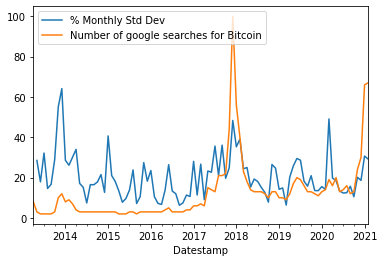

<Figure size 432x288 with 0 Axes>

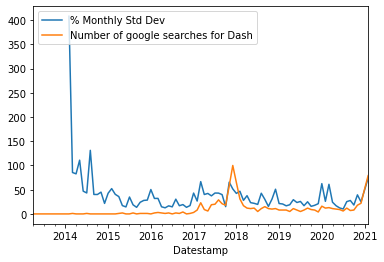

<Figure size 432x288 with 0 Axes>

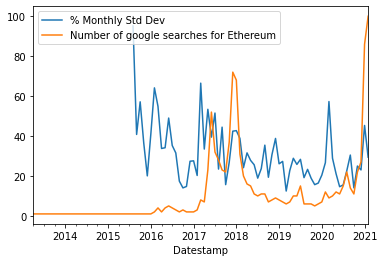

<Figure size 432x288 with 0 Axes>

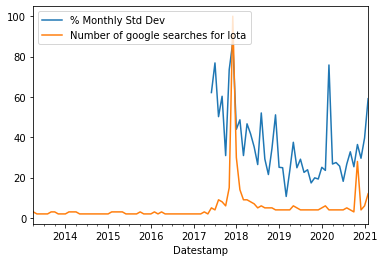

<Figure size 432x288 with 0 Axes>

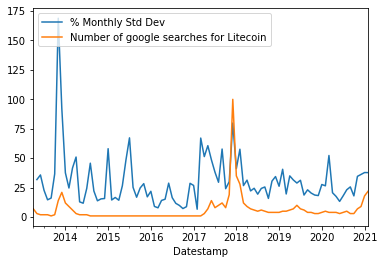

<Figure size 432x288 with 0 Axes>

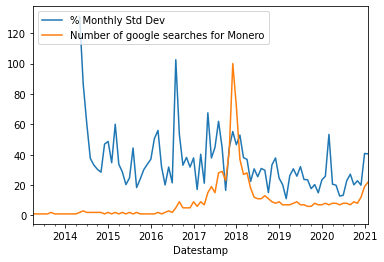

<Figure size 432x288 with 0 Axes>

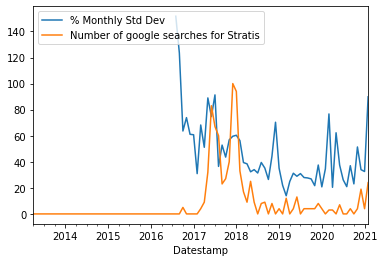

In [46]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlystd%', label='% Monthly Std Dev')")
    google_trends_df.plot(ax=ax, x='Datestamp', y=coin, label=(f'Number of google searches for {coin}'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/StdVsGoogleSearches1{coin}.png')")

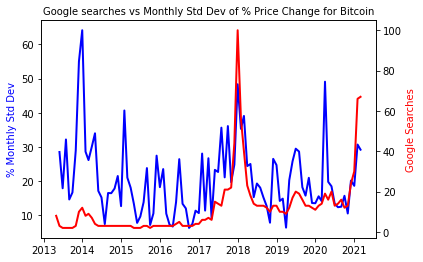

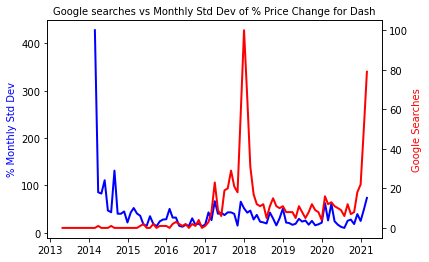

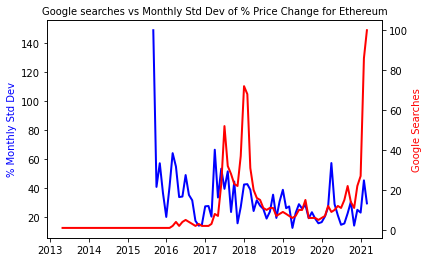

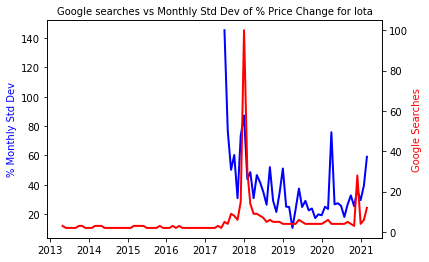

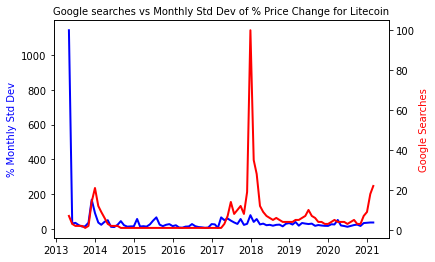

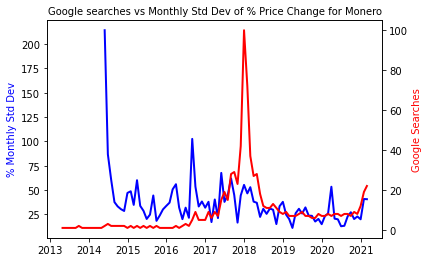

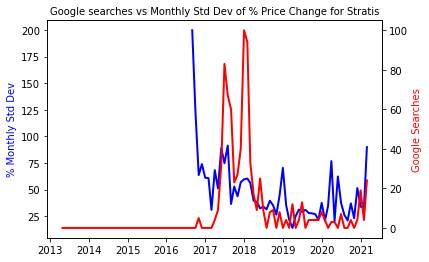

In [39]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlystd%'], 'b-', linewidth=2.0)")
    ax2.plot_date(google_trends_df.index, google_trends_df[coin], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Google searches vs Monthly Std Dev of % Price Change for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"% Monthly Std Dev", color='b', fontsize=10)
    ax2.set_ylabel("Google Searches", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/StdVsGoogleSearches2{coin}.png')")  
    
    plt.show()

#####   - on Volume of sales

<Figure size 432x288 with 0 Axes>

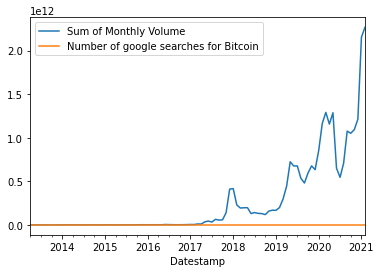

<Figure size 432x288 with 0 Axes>

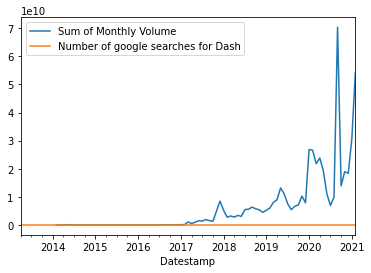

<Figure size 432x288 with 0 Axes>

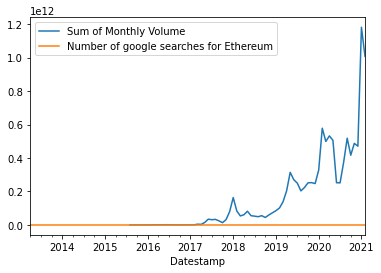

<Figure size 432x288 with 0 Axes>

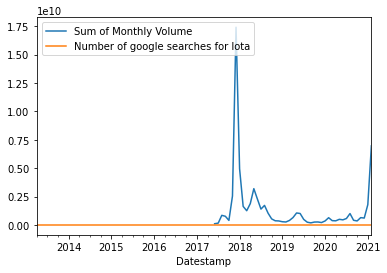

<Figure size 432x288 with 0 Axes>

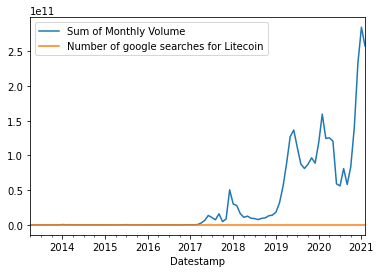

<Figure size 432x288 with 0 Axes>

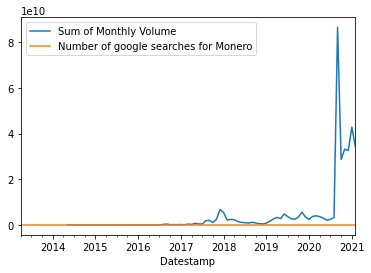

<Figure size 432x288 with 0 Axes>

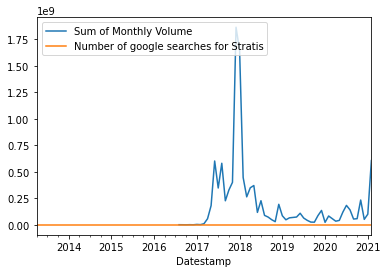

In [123]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlyvolsum', label='Sum of Monthly Volume')")
    google_trends_df.plot(ax=ax, x='Datestamp', y=coin, label=(f'Number of google searches for {coin}'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/VolVsGoogleSearches1{coin}.png')")

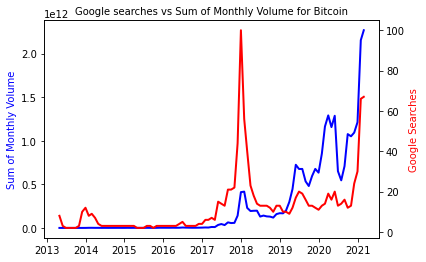

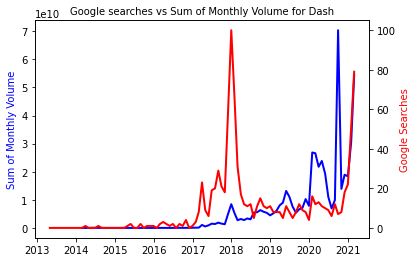

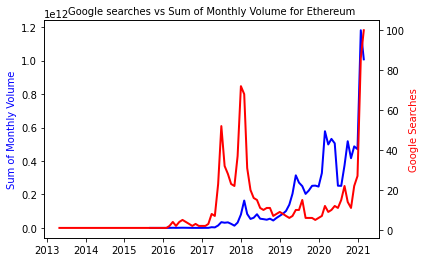

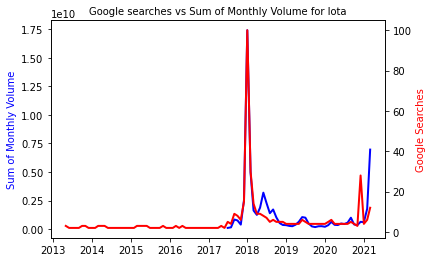

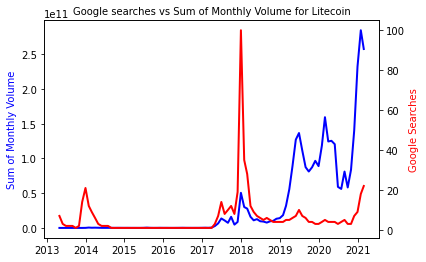

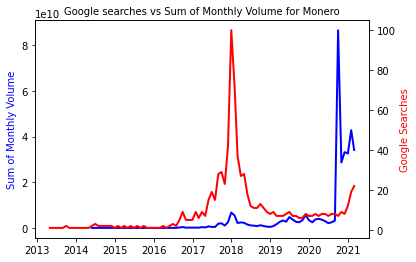

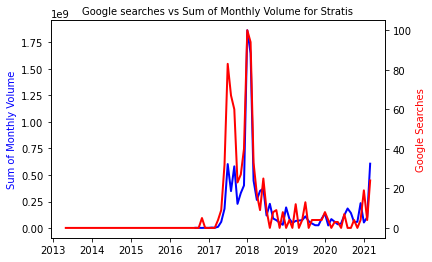

In [38]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlyvolsum'], 'b-', linewidth=2.0)")
    ax2.plot_date(google_trends_df.index, google_trends_df[coin], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Google searches vs Sum of Monthly Volume for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"Sum of Monthly Volume", color='b', fontsize=10)
    ax2.set_ylabel("Google Searches", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/VolVsGoogleSearches2{coin}.png')")  
    
    plt.show()

#####   - on Average Closing Price

<Figure size 432x288 with 0 Axes>

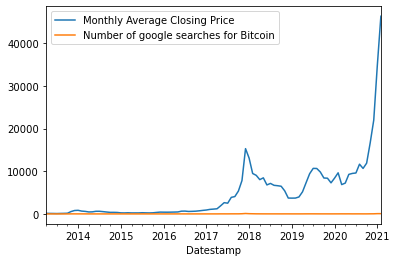

<Figure size 432x288 with 0 Axes>

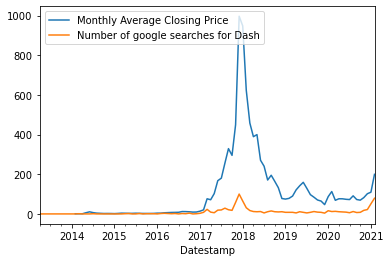

<Figure size 432x288 with 0 Axes>

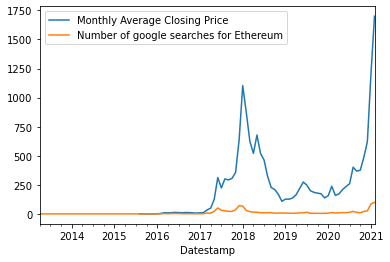

<Figure size 432x288 with 0 Axes>

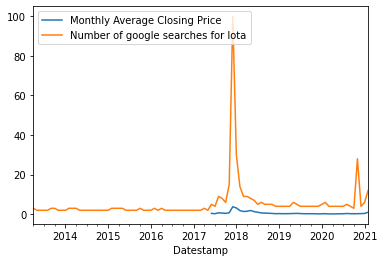

<Figure size 432x288 with 0 Axes>

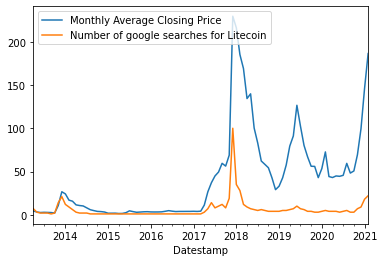

<Figure size 432x288 with 0 Axes>

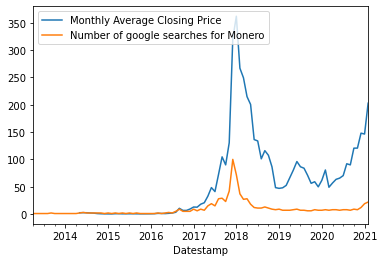

<Figure size 432x288 with 0 Axes>

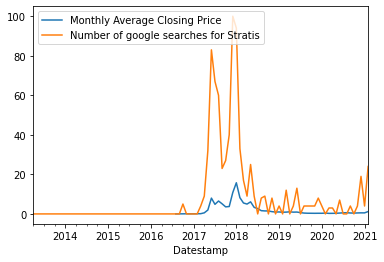

In [127]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlyavgprice', label='Monthly Average Closing Price')")
    google_trends_df.plot(ax=ax, x='Datestamp', y=coin, label=(f'Number of google searches for {coin}'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/PriceVsGoogleSearches1{coin}.png')")

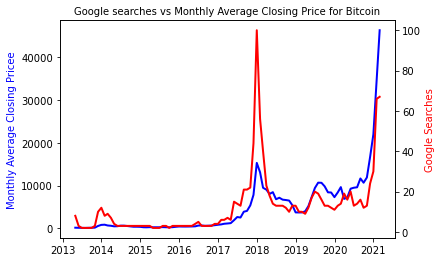

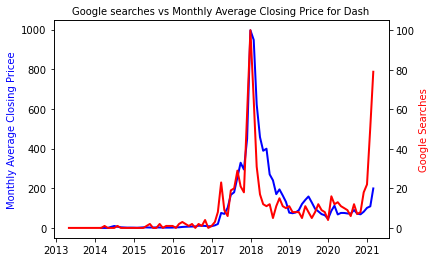

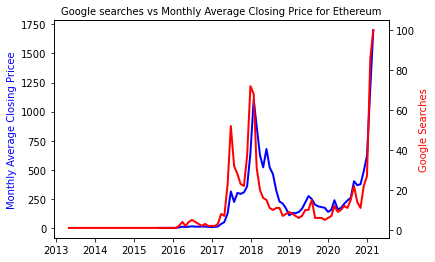

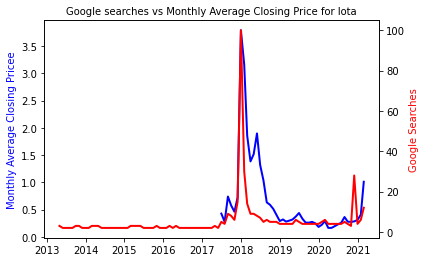

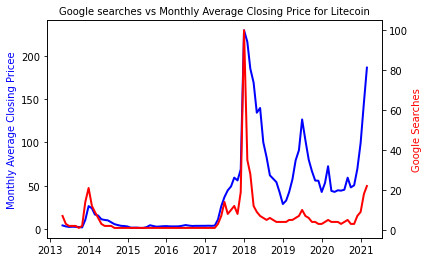

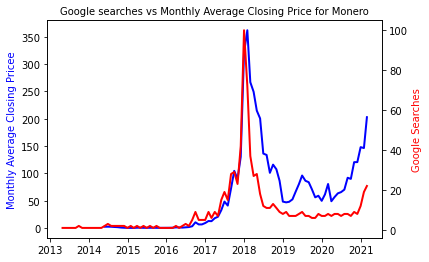

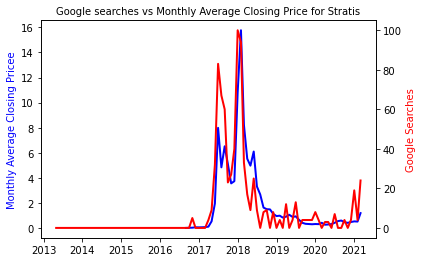

In [40]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlyavgprice'], 'b-', linewidth=2.0)")
    ax2.plot_date(google_trends_df.index, google_trends_df[coin], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Google searches vs Monthly Average Closing Price for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"Monthly Average Closing Pricee", color='b', fontsize=10)
    ax2.set_ylabel("Google Searches", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/PriceVsGoogleSearches2{coin}.png')")  
    
    plt.show()

#### Main media articles influence:

#####   - on Standard Deviation

<Figure size 432x288 with 0 Axes>

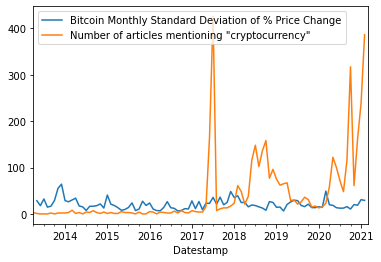

<Figure size 432x288 with 0 Axes>

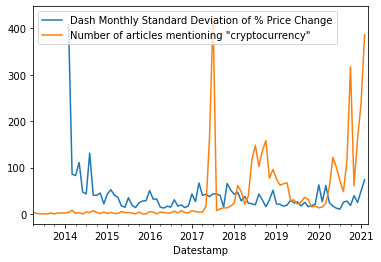

<Figure size 432x288 with 0 Axes>

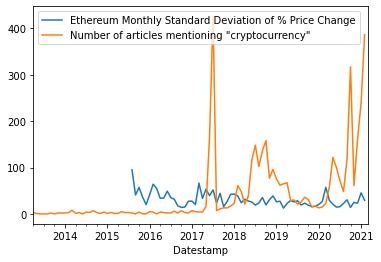

<Figure size 432x288 with 0 Axes>

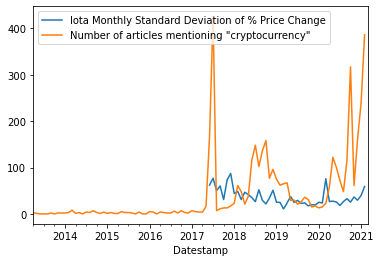

<Figure size 432x288 with 0 Axes>

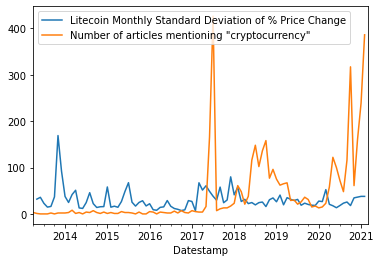

<Figure size 432x288 with 0 Axes>

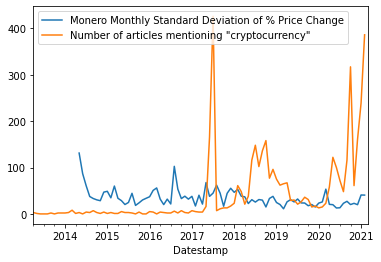

<Figure size 432x288 with 0 Axes>

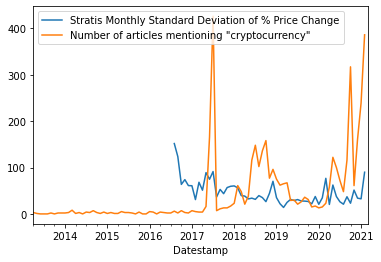

In [47]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlystd%', label='{coin} Monthly Standard Deviation of % Price Change')")
    news_df.plot(ax=ax, x='Datestamp', y='Num_of_articles', label=(f'Number of articles mentioning "cryptocurrency"'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/StdVsArticles1{coin}.png')")

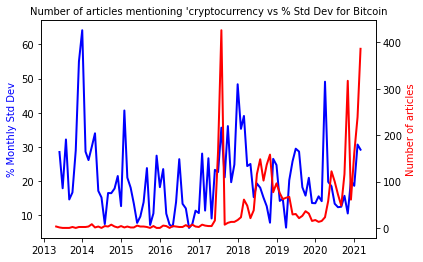

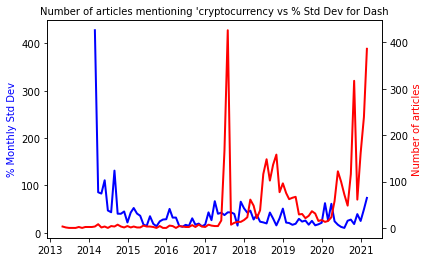

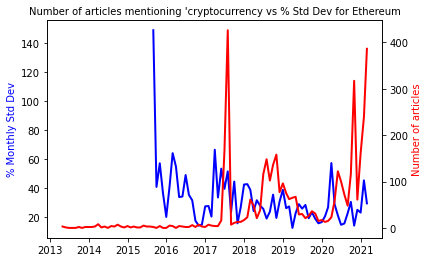

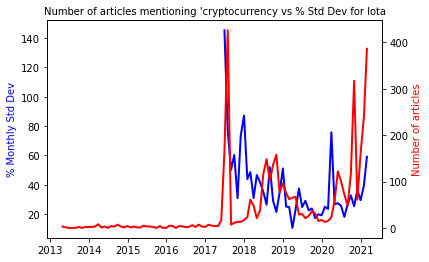

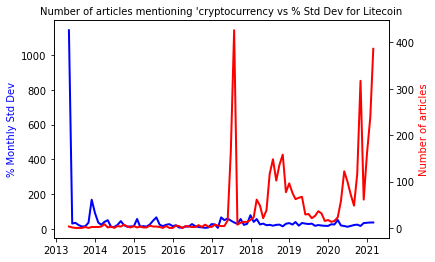

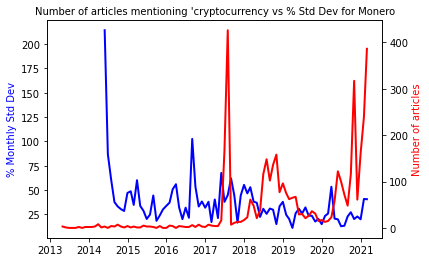

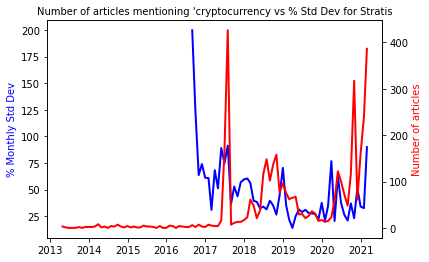

In [41]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlystd%'], 'b-', linewidth=2.0)")
    ax2.plot_date(news_df.index, news_df['Num_of_articles'], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Number of articles mentioning 'cryptocurrency vs % Std Dev for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"% Monthly Std Dev", color='b', fontsize=10)
    ax2.set_ylabel("Number of articles", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/StdVsArticles2{coin}.png')")  
    
    plt.show()

#####   - on Volume of sales

<Figure size 432x288 with 0 Axes>

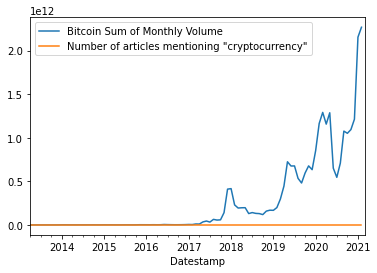

<Figure size 432x288 with 0 Axes>

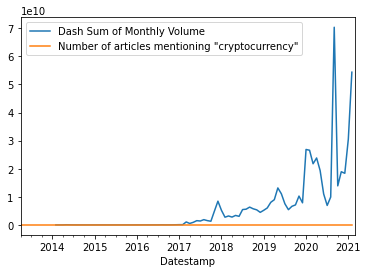

<Figure size 432x288 with 0 Axes>

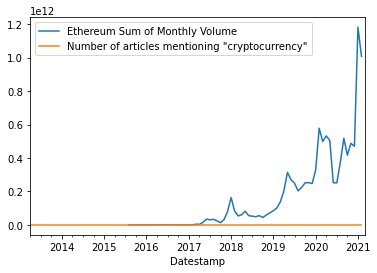

<Figure size 432x288 with 0 Axes>

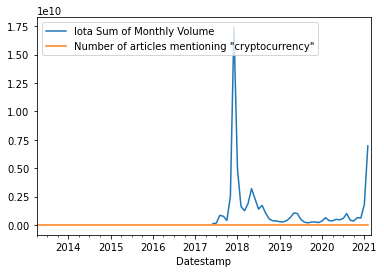

<Figure size 432x288 with 0 Axes>

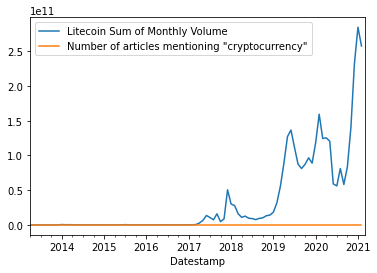

<Figure size 432x288 with 0 Axes>

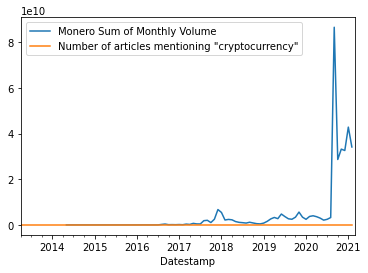

<Figure size 432x288 with 0 Axes>

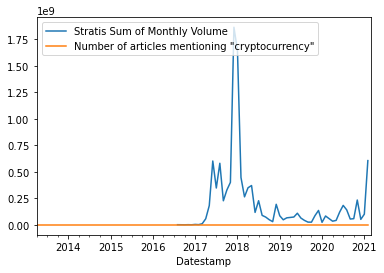

In [134]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlyvolsum', label='{coin} Sum of Monthly Volume')")
    news_df.plot(ax=ax, x='Datestamp', y='Num_of_articles', label=(f'Number of articles mentioning "cryptocurrency"'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/VolVsArticles1{coin}.png')")

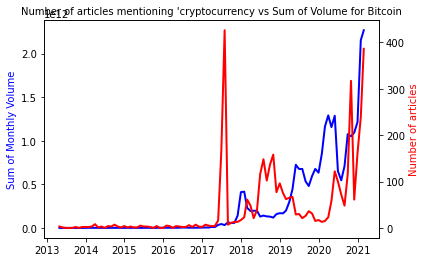

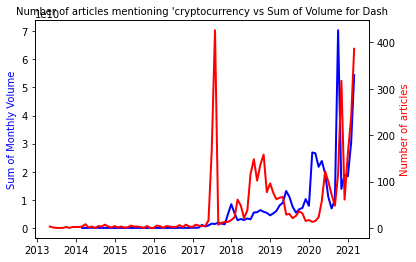

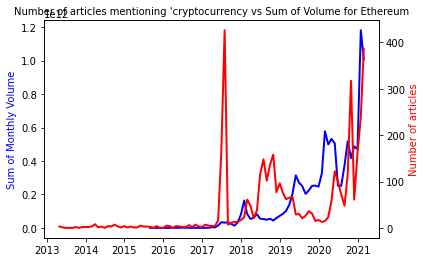

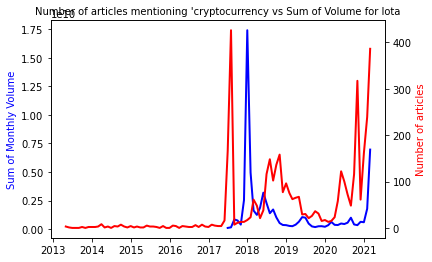

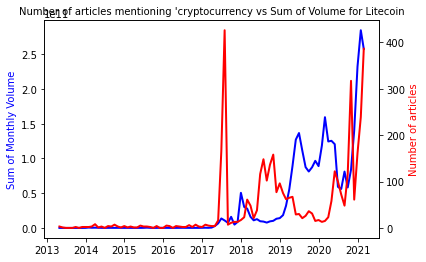

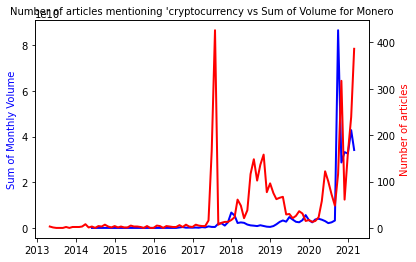

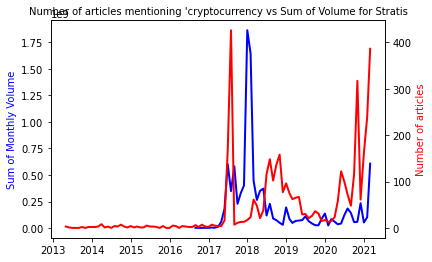

In [42]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlyvolsum'], 'b-', linewidth=2.0)")
    ax2.plot_date(news_df.index, news_df['Num_of_articles'], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Number of articles mentioning 'cryptocurrency vs Sum of Volume for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"Sum of Monthly Volume", color='b', fontsize=10)
    ax2.set_ylabel("Number of articles", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/VolVsArticles2{coin}.png')")  
    
    plt.show()

#####   - on Average Closing Price

<Figure size 432x288 with 0 Axes>

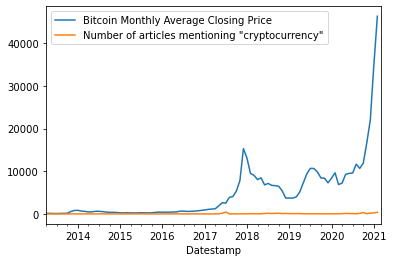

<Figure size 432x288 with 0 Axes>

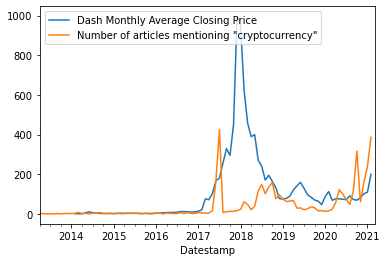

<Figure size 432x288 with 0 Axes>

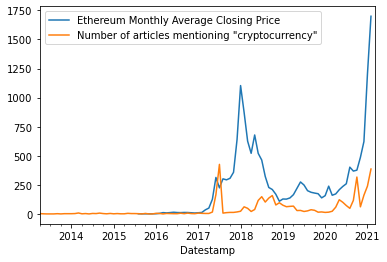

<Figure size 432x288 with 0 Axes>

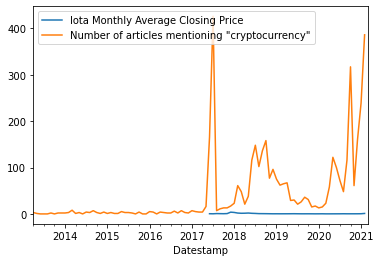

<Figure size 432x288 with 0 Axes>

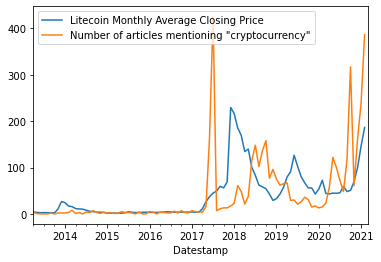

<Figure size 432x288 with 0 Axes>

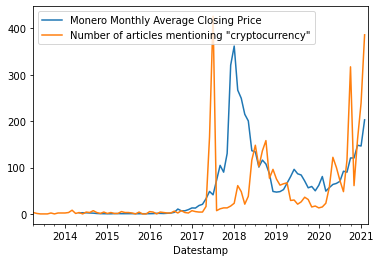

<Figure size 432x288 with 0 Axes>

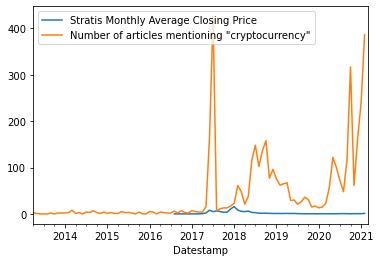

In [137]:
# Version 1
for coin in m_coinlist:
    plt.figure()
    exec(f"ax = {coin}_groupbymth_all_df.plot(x ='Datestamp',y ='monthlyavgprice', label='{coin} Monthly Average Closing Price')")
    news_df.plot(ax=ax, x='Datestamp', y='Num_of_articles', label=(f'Number of articles mentioning "cryptocurrency"'))
    plt.legend(loc = "upper left")
    exec(f"plt.savefig('Output/PriceVsArticles1{coin}.png')")

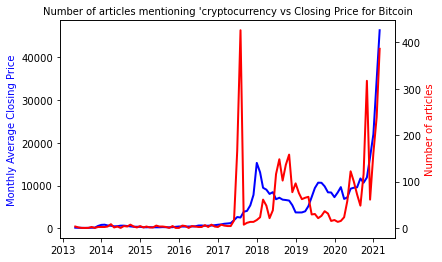

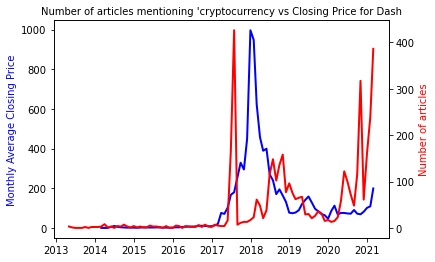

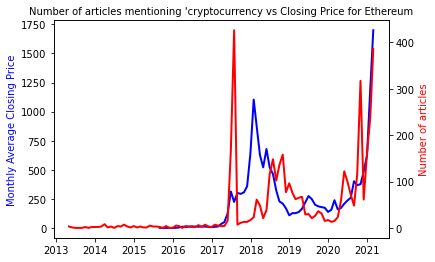

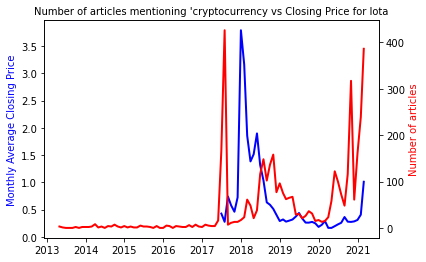

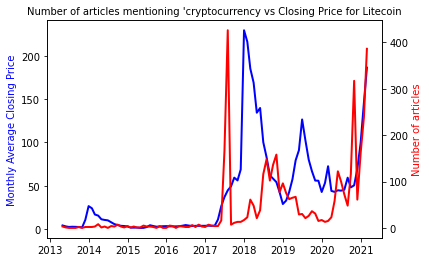

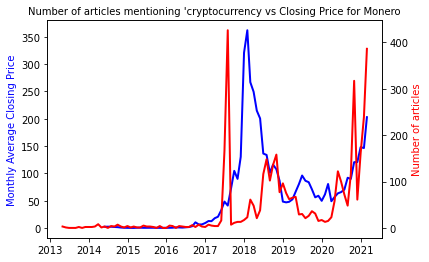

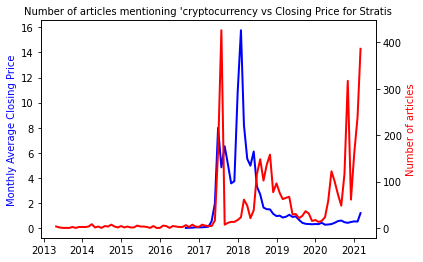

In [43]:
# Version 2
for coin in m_coinlist:   
    fig, ax1 = plt.subplots(figsize=(6,4))        
    ax2 = ax1.twinx()    
    
    exec(f"ax1.plot_date({coin}_groupbymth_all_df.index, {coin}_groupbymth_all_df['monthlyavgprice'], 'b-', linewidth=2.0)")
    ax2.plot_date(news_df.index, news_df['Num_of_articles'], 'r-', linewidth=2.0)
    
    ax1.set_title(f"Number of articles mentioning 'cryptocurrency vs Closing Price for {coin}", fontsize=10)
    ax1.tick_params(labelsize=10)
    ax1.set_ylabel(f"Monthly Average Closing Price", color='b', fontsize=10)
    ax2.set_ylabel("Number of articles", color='r', fontsize=10)
    
    exec(f"plt.savefig('Output/PriceVsArticles2{coin}.png')")  
    
    plt.show()

In [48]:
# Milena - Analysis and Graphing
#Pearson r-values calculation

#### Correlations:

In [49]:
# create new inner merged Data Frames, in order to create series equal in length for Pearson r-values calculation
merge_news_df = news_df.copy()
merge_news_df= merge_news_df.reset_index(drop=True)

In [50]:
merge_google_df = google_trends_df.copy()
merge_google_df= merge_google_df.reset_index(drop=True)

In [51]:
merge_df = pd.merge(merge_news_df, merge_google_df, on="Datestamp", how="outer")
merge_df.head()

,Datestamp,Num_of_articles,Bitcoin,Ethereum,Litecoin,Iota,Monero,Dash,Stratis
0,2013-04-30,3.0,8.0,1.0,7.0,3.0,1.0,0.0,0.0
1,2013-05-31,1.0,3.0,1.0,3.0,2.0,1.0,0.0,0.0
2,2013-06-30,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0
3,2013-07-31,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0
4,2013-08-31,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0


In [52]:
for coin in coinlist:
    # create a new dataframe for each coin and reset index
    exec(f"new_{coin}_gbm_all_n_df = {coin}_groupbymth_all_df.copy()")
    exec(f"new_{coin}_gbm_all_n_df= new_{coin}_gbm_all_n_df.reset_index(drop=True)")

    # remove not required columns
    exec(f"del new_{coin}_gbm_all_n_df['dailystd%']")
    exec(f"del new_{coin}_gbm_all_n_df['monthlyvolsum']")

    # merge the coin dataframe with the one with media data
    exec(f"{coin}_merge_df = pd.merge(merge_df, new_{coin}_gbm_all_n_df, on='Datestamp', how='inner')")         
    exec(f"{coin}_merge_df = {coin}_merge_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)")

In [53]:
Bitcoin_merge_df.head()

,Datestamp,Num_of_articles,Bitcoin,Ethereum,Litecoin,Iota,Monero,Dash,Stratis,monthlystd%,monthlyavgprice
1,2013-05-31,1.0,3.0,1.0,3.0,2.0,1.0,0.0,0.0,28.509281,119.992581
2,2013-06-30,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,17.901821,107.761333
3,2013-07-31,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,32.174397,90.512258
4,2013-08-31,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,14.622028,113.905161
5,2013-09-30,2.0,2.0,1.0,1.0,3.0,2.0,0.0,0.0,16.676653,130.061667


In [54]:
# correlation between volatility and google search
vvs_list = []

for coin in coinlist: 
    exec(f"stdcoin = {coin}_merge_df['monthlystd%']")
    exec(f"search = {coin}_merge_df[coin]")
         
    print(f"The correlation between volatility and google search for {coin} is {round(st.pearsonr(stdcoin,search)[0],2)}\n")
    vvs_list.append(round(st.pearsonr(stdcoin,search)[0],2))

The correlation between volatility and google search for Bitcoin is 0.42

The correlation between volatility and google search for Ethereum is 0.1

The correlation between volatility and google search for Litecoin is 0.42

The correlation between volatility and google search for Iota is 0.5

The correlation between volatility and google search for Monero is 0.14

The correlation between volatility and google search for Dash is 0.04



In [55]:
# correlation between price and google search
pvs_list = []

for coin in coinlist:  
    exec(f"price = {coin}_merge_df['monthlyavgprice']")
    exec(f"search = {coin}_merge_df[coin]")
         
    print(f"The correlation between price and google search for {coin} is {round(st.pearsonr(price,search)[0],2)}\n")
    pvs_list.append(round(st.pearsonr(price,search)[0],2))

The correlation between price and google search for Bitcoin is 0.78

The correlation between price and google search for Ethereum is 0.87

The correlation between price and google search for Litecoin is 0.69

The correlation between price and google search for Iota is 0.77

The correlation between price and google search for Monero is 0.82

The correlation between price and google search for Dash is 0.78



In [56]:
# correlation between volatility and number of articles
vva_list = []

for coin in coinlist:  
    exec(f"stdcoin = {coin}_merge_df['monthlystd%']")
    exec(f"article = {coin}_merge_df['Num_of_articles']")
         
    print(f"The correlation between volatility and number of articles for {coin} is {round(st.pearsonr(stdcoin,article)[0],2)}\n")
    
    vva_list.append(round(st.pearsonr(stdcoin,article)[0],2))

The correlation between volatility and number of articles for Bitcoin is 0.05

The correlation between volatility and number of articles for Ethereum is -0.08

The correlation between volatility and number of articles for Litecoin is -0.0

The correlation between volatility and number of articles for Iota is 0.2

The correlation between volatility and number of articles for Monero is -0.14

The correlation between volatility and number of articles for Dash is -0.06



In [57]:
# correlation between price and number of articles

pva_list = []

for coin in coinlist:  
    exec(f"price = {coin}_merge_df['monthlyavgprice']")
    exec(f"article = {coin}_merge_df['Num_of_articles']")
         
    print(f"The correlation between price and number of articles for {coin} is {round(st.pearsonr(price,article)[0],2)}\n")
    
    pva_list.append(round(st.pearsonr(price,article)[0],2))

The correlation between price and number of articles for Bitcoin is 0.63

The correlation between price and number of articles for Ethereum is 0.54

The correlation between price and number of articles for Litecoin is 0.4

The correlation between price and number of articles for Iota is -0.13

The correlation between price and number of articles for Monero is 0.35

The correlation between price and number of articles for Dash is 0.15



In [58]:
# put all results into DataFrame
merge_dict = { 'Currency': coinlist,
               'Correlation between volatility and google search': vvs_list,
               'Correlation between price and google search': pvs_list,
               'Correlation between volatility and number of articles': vva_list,
               'Correlation between price and number of articles': pva_list }

In [59]:
correlation_df = pd.DataFrame(merge_dict)
correlation_df = correlation_df.set_index('Currency')
correlation_df

,Correlation between volatility and google search,Correlation between price and google search,Correlation between volatility and number of articles,Correlation between price and number of articles
Currency,,,,
Bitcoin,0.42,0.78,0.05,0.63
Ethereum,0.10,0.87,-0.08,0.54
Litecoin,0.42,0.69,-0.00,0.40
Iota,0.50,0.77,0.20,-0.13
Monero,0.14,0.82,-0.14,0.35
Dash,0.04,0.78,-0.06,0.15


## Final Conclusions

**It appears that Cryptocurrencies are indeed more volatile than traditional currencies**
  *  The graphs showing Standard Deviation of Traditional currencies vs Crypto currencies is off the scale
  *  Price growth and price swings of cryptocurrency is significantly greater than traditional currencies

**It’s hard to fully determine if Cryptocurrency volatility is stabilizing over time. The data suggests otherwise, that volatility has actually increased overall since the concept went mainstream. However, certain factors, including a drop in the differential of Mean Percentage Change Per Month, and a decrease in Log Return of Standard Deviation for all the concerns following the 2018 boom, suggests that in some respects they are more stable following the 2018 boom.** 
  *  The min & max graphs seems to suggest that after cryptocurrency went mainstream in mid 2017, price volatility has increased significantly 
  *  The standard deviation graphs seem to suggest that the variance of prices in a given month has increased since mid 2017
  *  The % change per month graph perhaps contradicts this, showing that the overall price changes have smoothed out 

**It appears that Social Media and Traditional Media do have correlations to various cryptocurrency trends, but that Social Media and Traditional Media are not influencing the volatility levels of cryptocurrency.** 
  *  There does appear to be a correlation between Social Media mentions and Traditional Media articles, versus the price and volatility of Cryptocurrency 
  *  There appears to be a clear correlation of the volume of cryptocurrency trades vs the number of google searches for the cryptocurrency 
  *  The more media and search activity received by cryptocurrencies, potentially results in price swings
  *  Bitcoin is particularly correlated to price gains and falls based on media and social media interest 
  *  Media covering is driving interest, which does seem to be correlated to price, but does not seem to be driving volatility 